In [2]:
import json

import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
from cv2 import Canny
from PIL import Image
from mrcnn.config import Config
ROOT_DIR = os.path.abspath("../")

sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import pycocotools

from pycocotools import coco
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "Building-Detection.h5")

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction = 0.3)
session = tf.InteractiveSession(
    config=tf.ConfigProto(gpu_options=gpu_options)
)

In [3]:
class SpaceNetConfig(Config):
    '''
        Configuration for SpaceNet Dataset
    '''

    # Configuration name
    NAME = "spaceNet1"

    # I have GTX 1050 Ti, 4 GB RAM
    # It did not work with resnet101. So, I used resnet50 for backbone
    BACKBONE = 'resnet50'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    BATCH_SIZE = 32
    NUM_CLASSES = 1 + 1  # 1 (Bulding + Backround)

    # Actually, all the training data is 650x650
    # but the input size should be the multiple of 2^6
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640
    
    # You can change regarding to yout datset
    STEPS_PER_EPOCH = 140
    DETECTION_MAX_INSTANCES = 90
    LEARNING_RATE = 0.001
    
    VALIDATION_STEPS = 10
    
    
config = SpaceNetConfig()

In [5]:
# Загрузка модели
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Грузим веса
model.load_weights('./sand/trained_weights.h5', by_name=True)

In [6]:
from mrcnn import utils
import colorsys
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
from skimage.measure import find_contours

############################################################
#  Visualization
#######################################################WARNING:tensorflow:From /home/mr9bit/Work/aviahack/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.#####

def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interporlation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()


def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def save_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            x = random.randint(x1, (x1 + x2) // 2)
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    return masked_image.astype(np.uint8)
        

In [14]:
from osgeo import osr, gdal
import numpy as np
import tifffile as tiff

def mask_approximation(bg_mask):
    contours, _ = cv2.findContours(bg_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    c = contours[0]
    peri = cv2.arcLength(c, closed=True)
    approx = cv2.approxPolyDP(c, epsilon=0.01 * peri, closed=True)
    # Delat threshold
    t = 5
    # n - Number of vertices
    n = approx.shape[0]

    for i in range(n):
    #      p1              p2
    #       *--------------*
    #       |
    #       |
    #       |
    #       *
    #      p0

        p0 = approx[(i+n-1) % n][0]    # Previous vertex
        p1 = approx[i][0]              # Current vertex
        p2 = approx[(i + 1) % n][0]    # Next vertex
        dx = p2[0] - p1[0]             # Delta pixels in horizontal direction
        dy = p2[1] - p1[1]             # Delta pixels in vertical direction

    # Fix x index of vertices p1 and p2 to be with same x coordinate ([<p1>, <p2>] form horizontal line).
        if abs(dx) < t:
            if ((dx < 0) and (p0[0] > p1[0])) or ((dx > 0) and (p0[0] < p1[0])):
                p2[0] = p1[0]
            else:
                p1[0] = p2[0]

    # Fix y index of vertices p1 and p2 to be with same y coordinate ([<p1>, <p2>] form vertical line).
        if abs(dy) < t:
            if ((dy < 0) and (p0[1] > p1[1])) or ((dy > 0) and (p0[1] < p1[1])):
                p2[1] = p1[1]
            else:
                p1[1] = p2[1]

        approx[i][0] = p1
        approx[(i + 1) % n][0] = p2
    return approx

def pixel2coord(x, y, raster):
    "Конвертер пикс в long и lat"
    xoff, a, b, yoff, d, e = raster.GetGeoTransform()

    xp = a * x + b * y + a * 0.5 + b * 0.5 + xoff
    yp = d * x + e * y + d * 0.5 + e * 0.5 + yoff
    return(xp, yp)

def get_mask_array(mask):
    overlay = np.ndarray(shape=(mask.shape[0],mask.shape[1]), dtype=np.uint8)
    mask_overlay = []
    for i in range(mask.shape[2]):
        for x in range(mask.shape[0]):
            for y in range(mask.shape[1]):
                if mask[x][y][i] == True:
                    overlay[x][y] = 255
                else:
                    overlay[x][y] = 0
        mask_overlay.append(overlay)
        overlay = np.ndarray(shape=(mask.shape[0],mask.shape[1]), dtype=np.uint8)
    return mask_overlay

def get_predict(tiff_path):
    """
        Только путь к tiff файлу
        Example:
        get_predict("./sand/v2.tif")
    """
    raster = gdal.Open(tiff_path)
    all_images = {}
    raster_array = tiff.imread(tiff_path)
    raster_array = raster_array[:,:,:3]
    img_tif = raster_array
    result = {}
    w, h= (1512, 1512)
    tiles = {}
    i = 0
    j = 0

    for x in range(0, img_tif.shape[0], w):
        for y in range(0, img_tif.shape[1], h):
            try:
                row = x
                column = y
                tile = img_tif[x:x+w, y:y+h]
            except IndexError:
                if x + w > img_tif.shape[0]:
                    row = -w
                if y + h > img_tif.shape[1]:
                    column = -h
                tile = img_tif[row:,column:]
            print(tile)
            tiles[(row, column)] = tile
        
    x_coords = np.array([])
    itter = 0
    y_coords = np.array([])
    coords = []
    for key in tiles.keys():
        #получаем тайл
        tile = tiles[key][:,:]
        #предиктим его
        pred = model.detect([tile])[0]
        #смотрим, если на нём есть что-то(если нет выделенных областей на изображении)
        if pred['rois'].shape[0] != 0:
            print('Mask found')
            mask = pred['masks']
        
            
            
            mask_overlay = get_mask_array(mask)
            for layer in mask_overlay:
                itter+=1
                countur = mask_approximation(layer)
                approx_gps = []
                print("Layer", "="*30)
                for px in countur:
                    x  = px[0][0]
                    y = px[0][1]
                    x_, y_ = pixel2coord(x + key[0], y + key[1], raster)
                    approx_gps.append([x_, y_])
                object_location = []
                all_images[key]=save_instances(tile, pred['rois'], pred['masks'], pred['class_ids'], 
                                    ['','building'],pred['scores'])
                print(f"Building {itter}")
                for x in approx_gps:
                    long = x[0]
                    lat = x[1]
                    object_location.append([lat, long])
                    print('[', lat, ',', long,']',',')
                
                result[f"Building {itter}"] = object_location
        else:
            all_images[key]=tile
    return result, all_images
            

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..

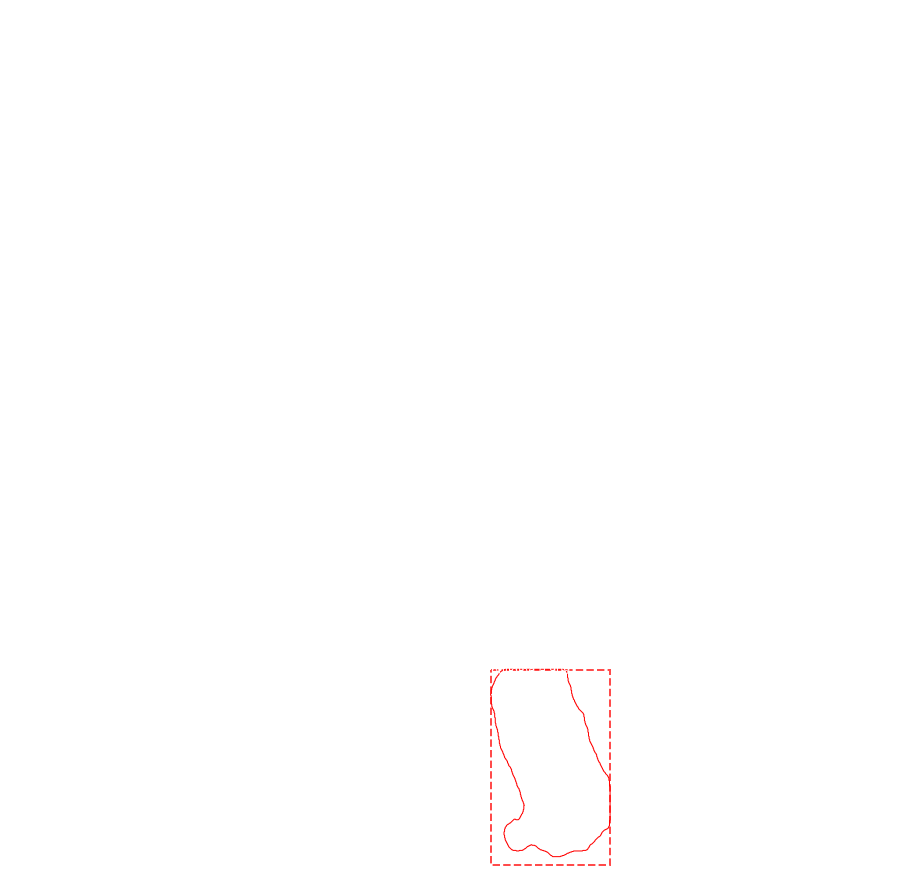

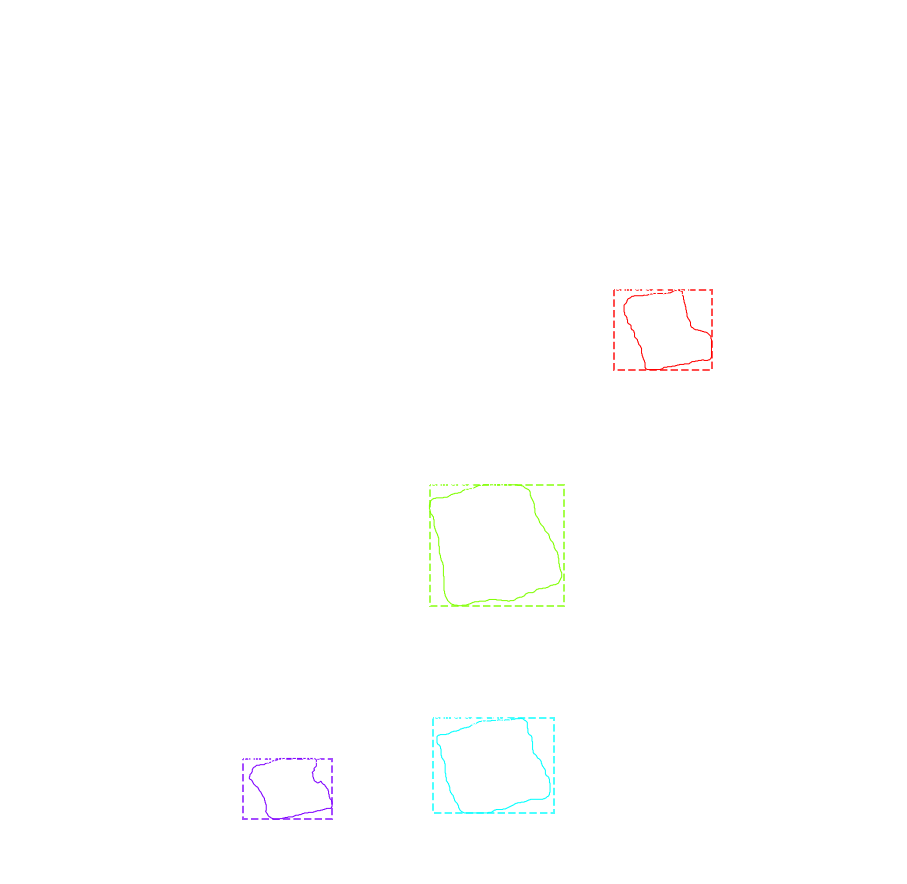

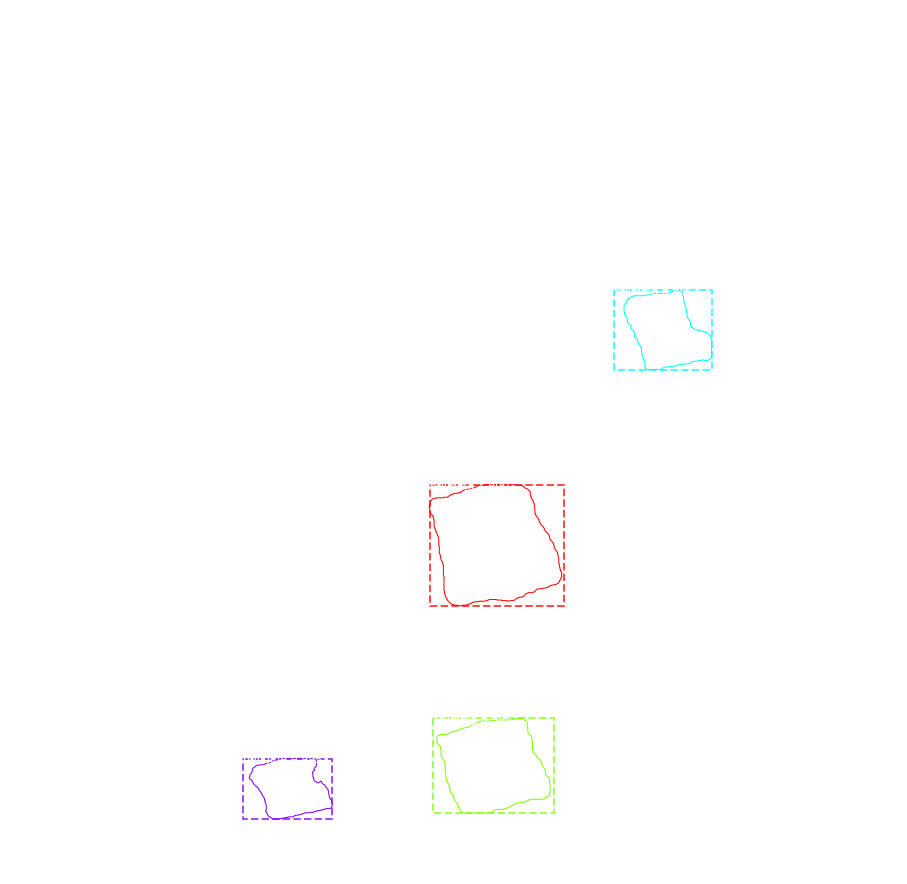

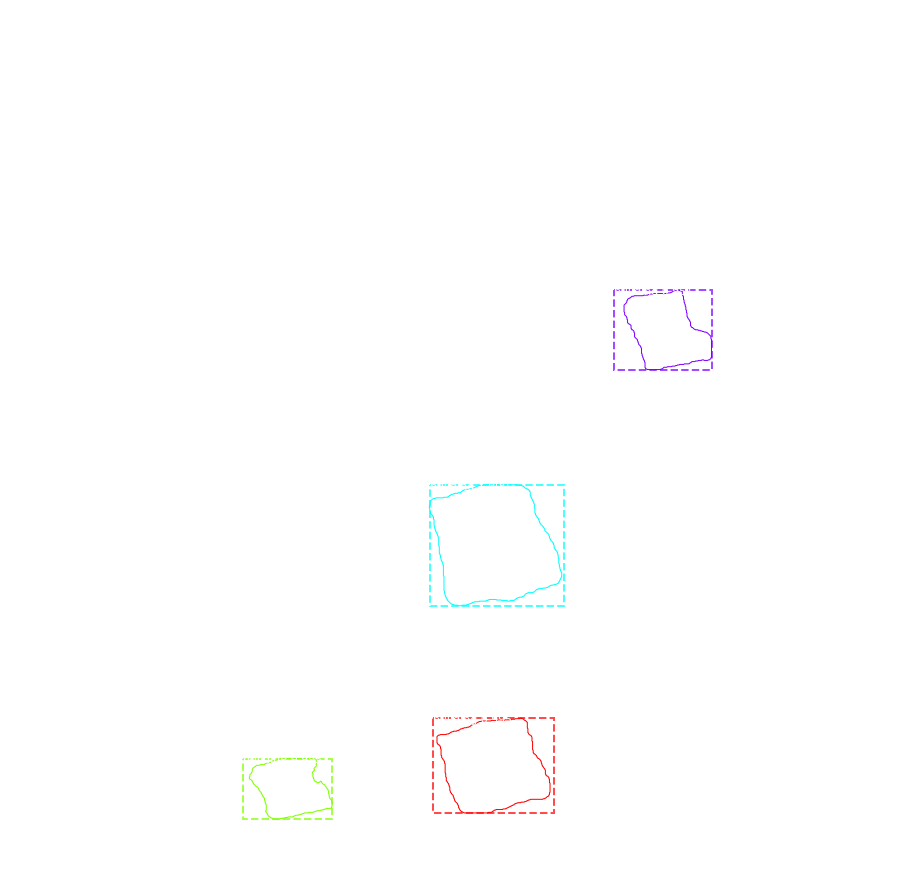

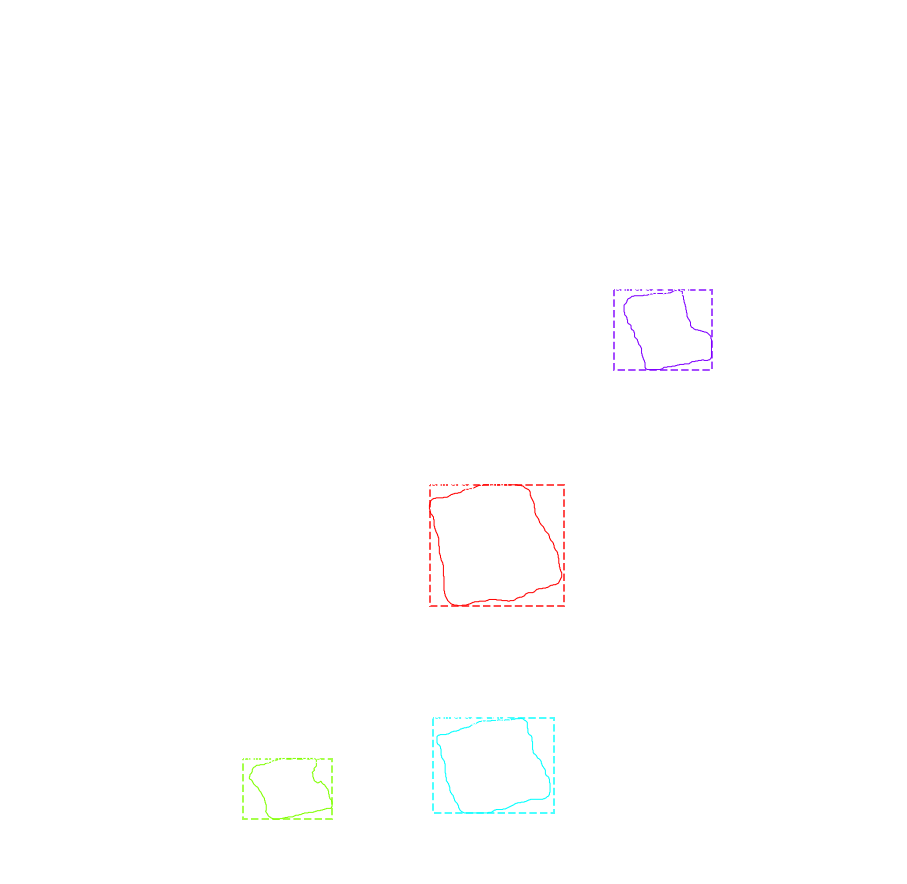

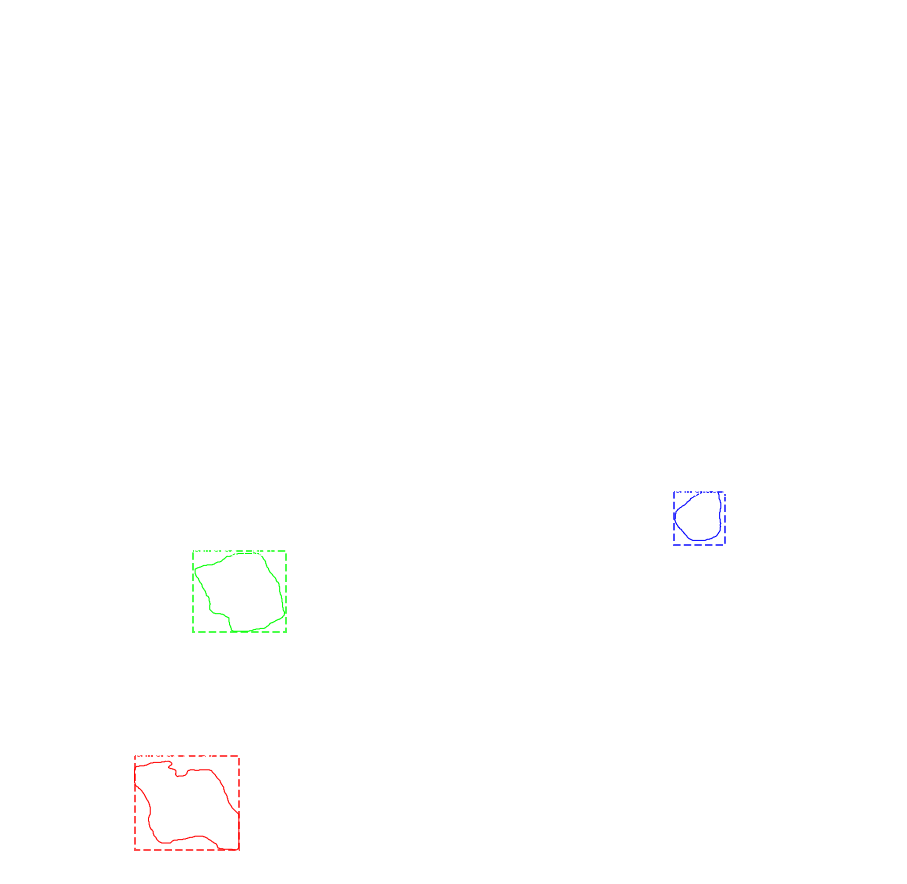

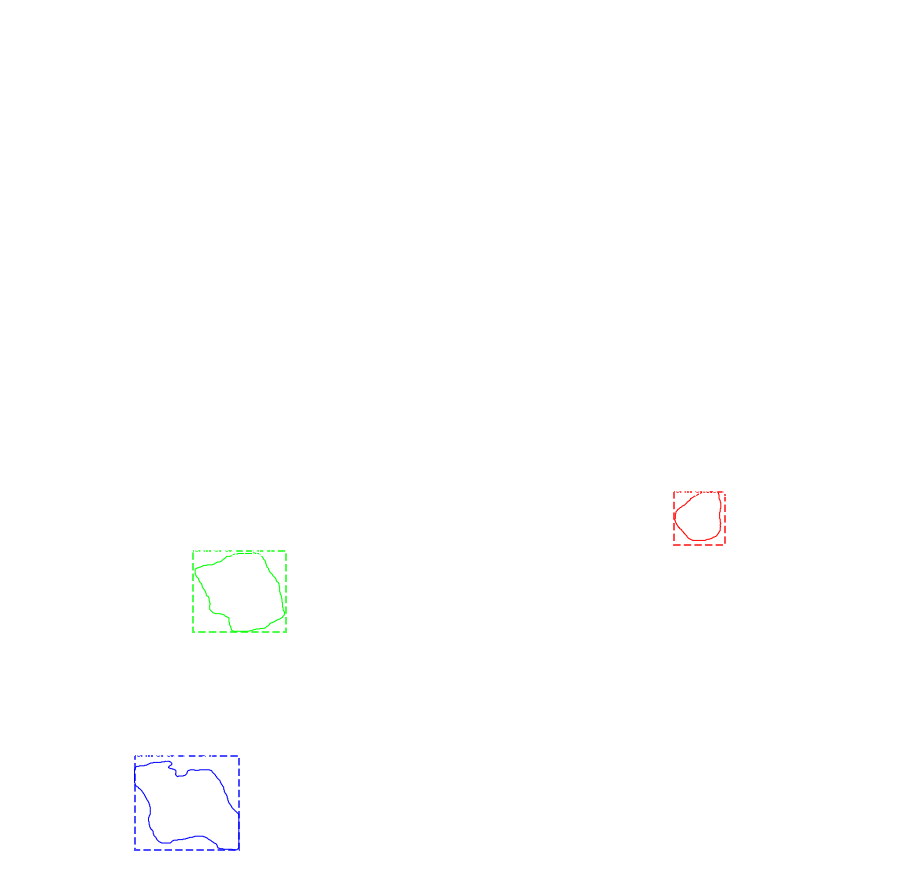

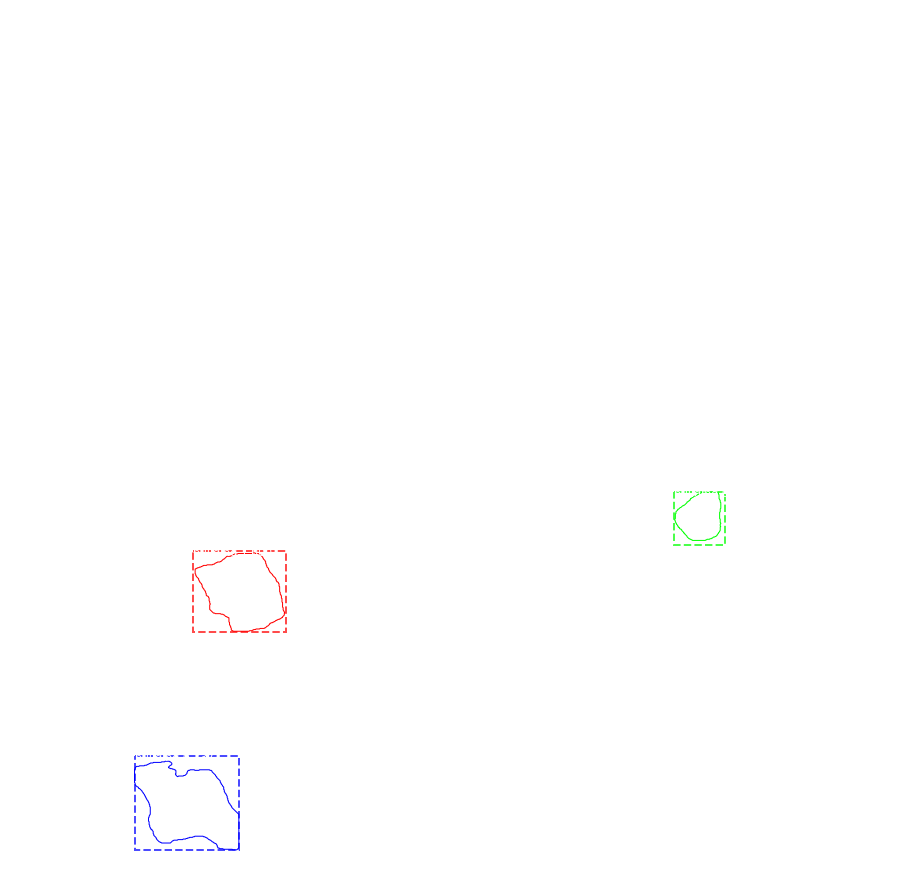

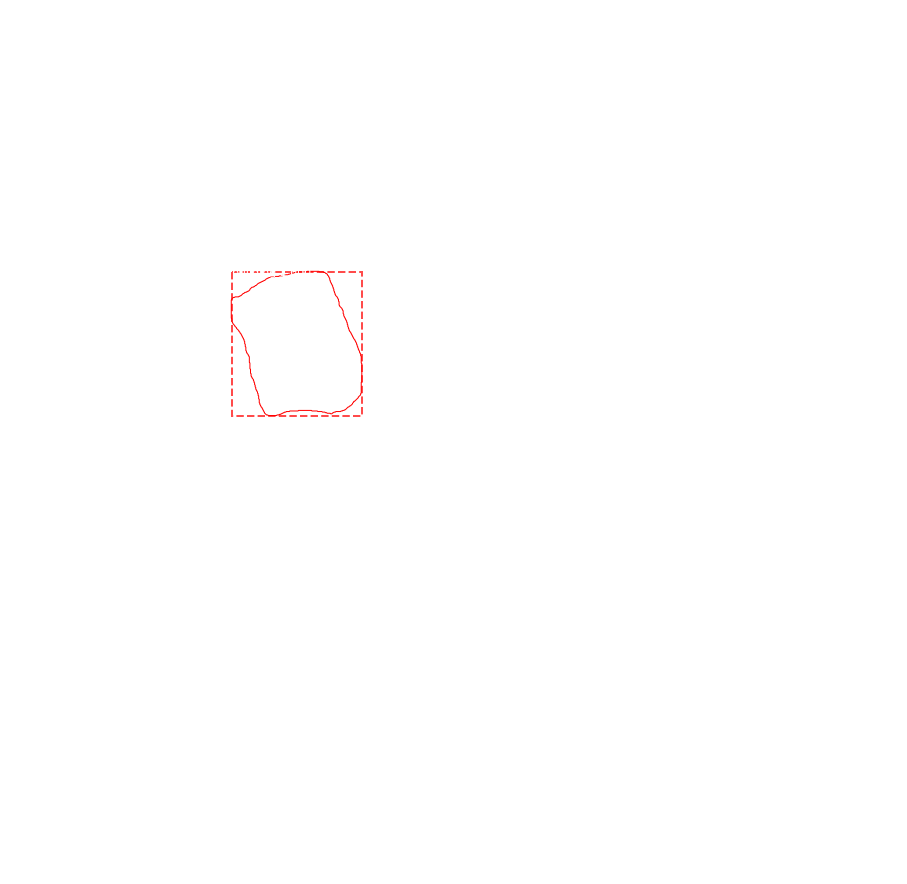

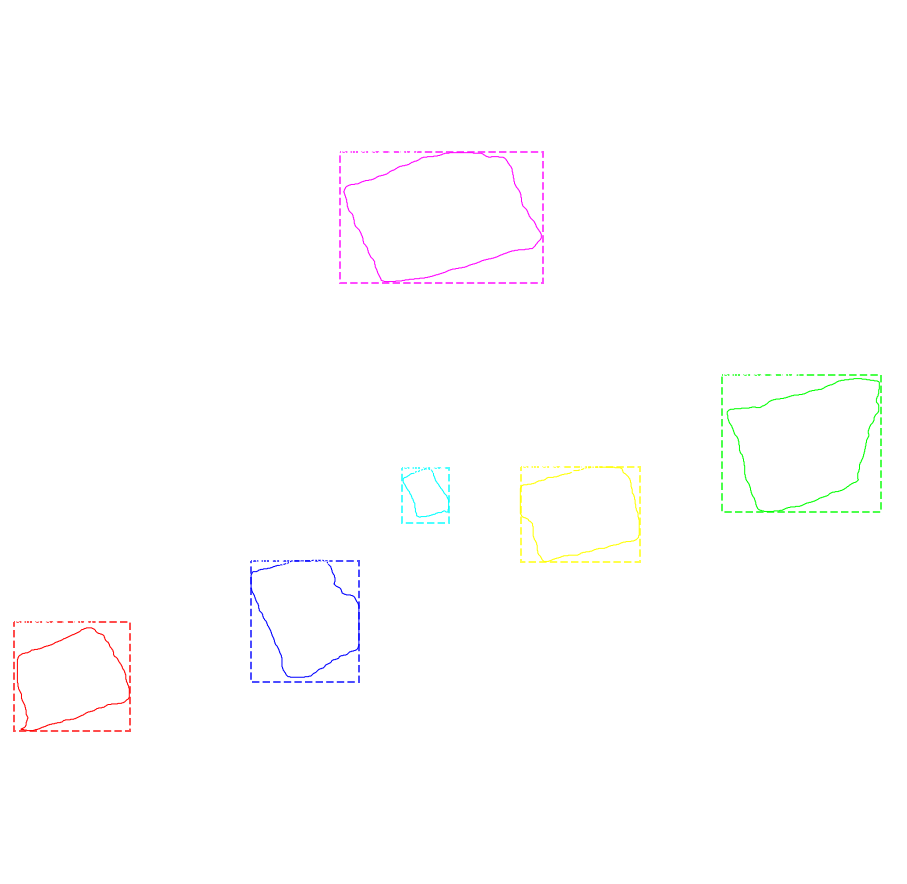

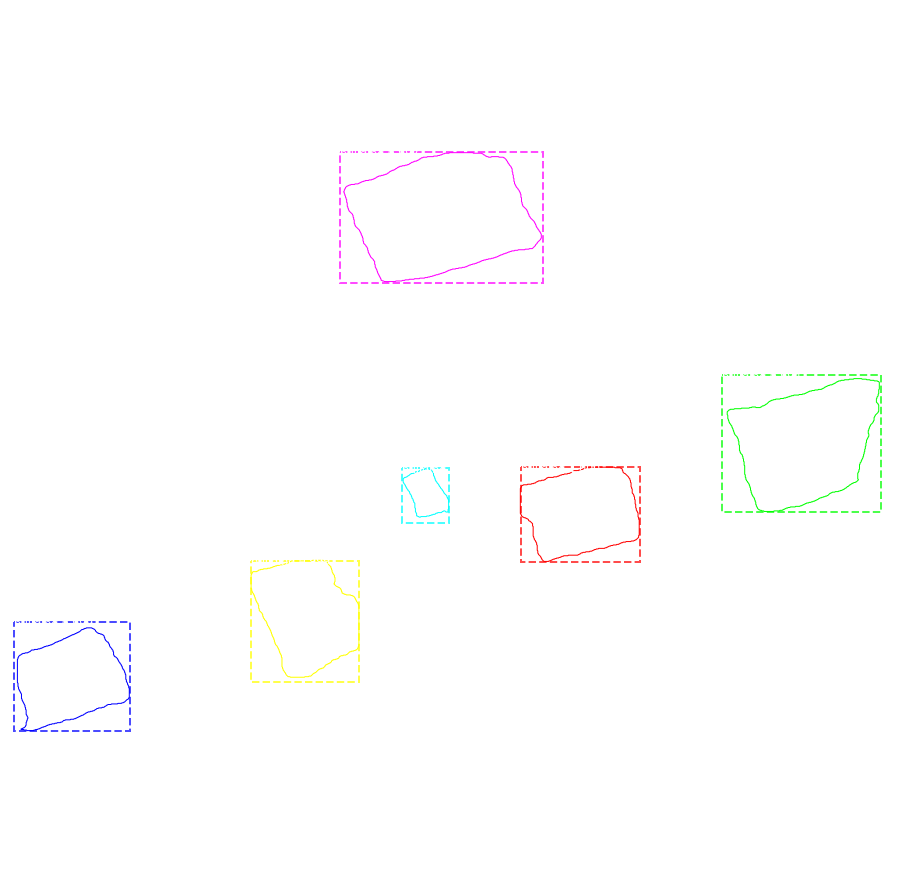

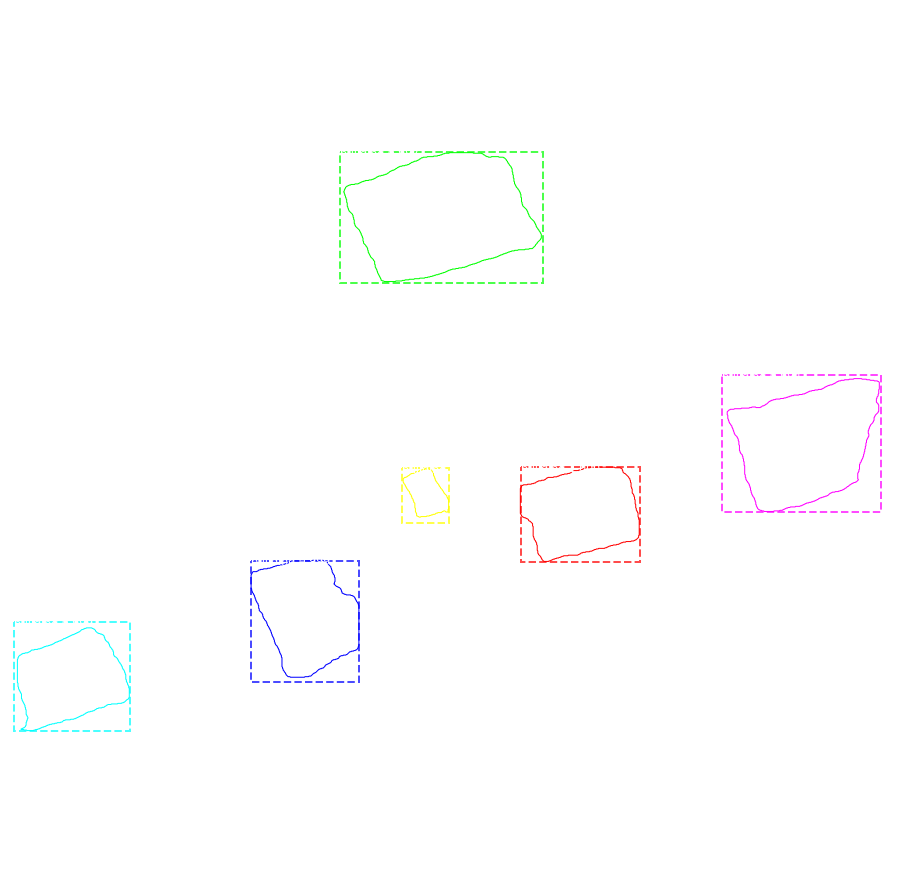

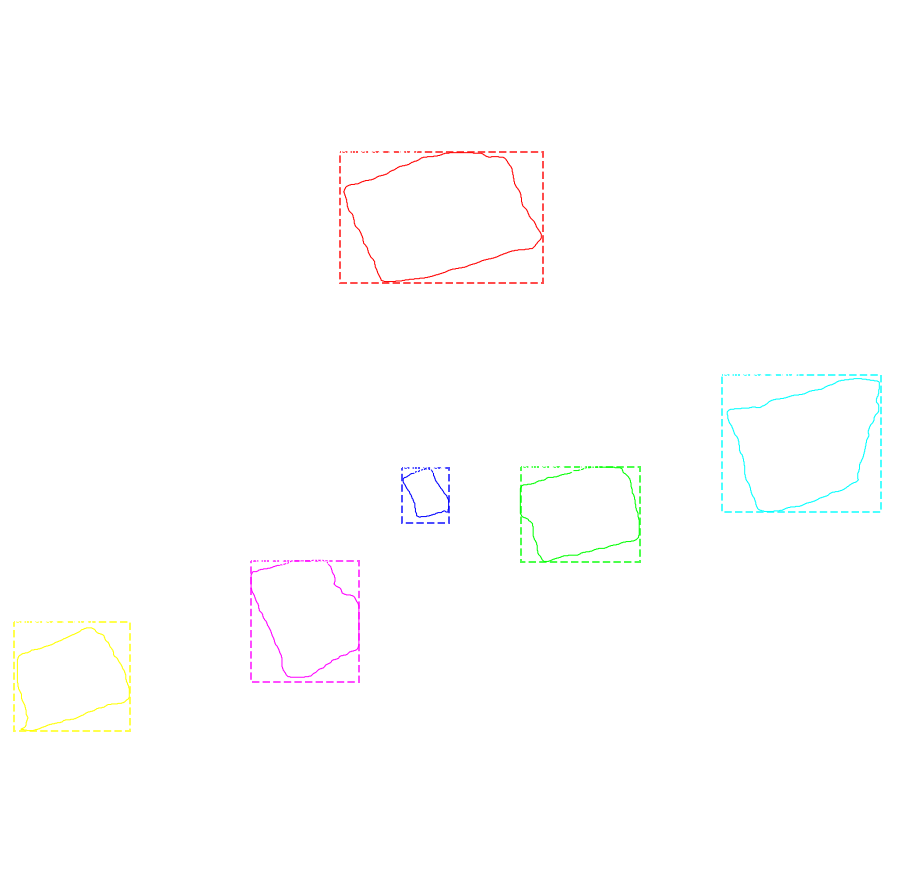

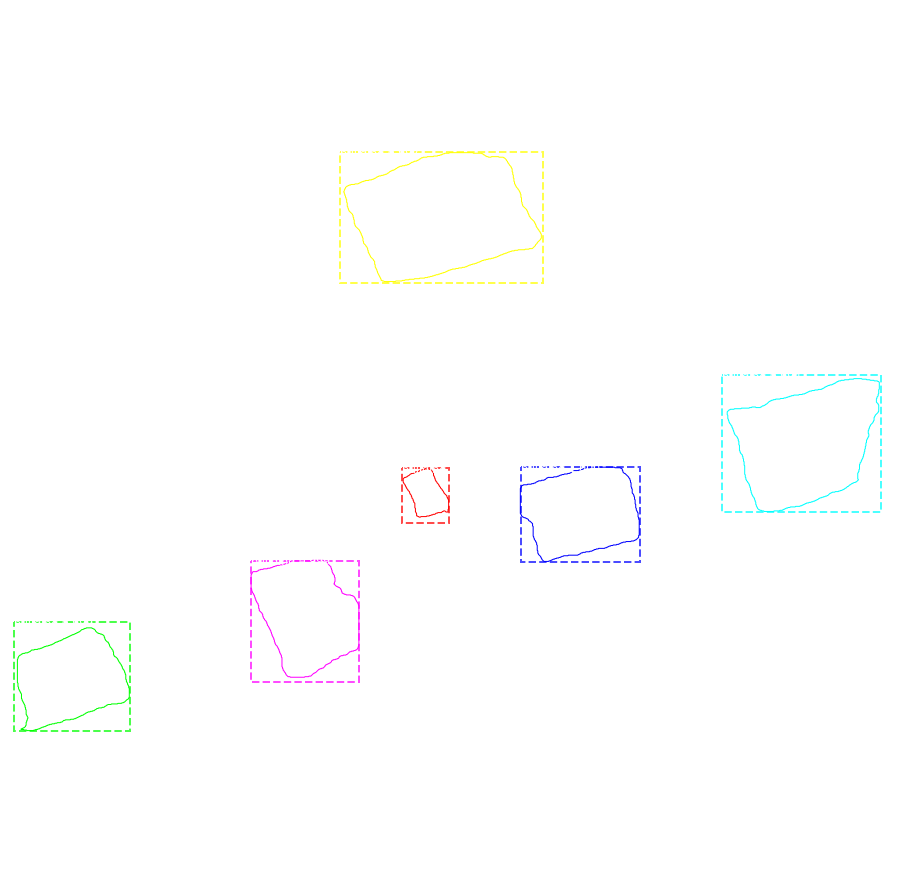

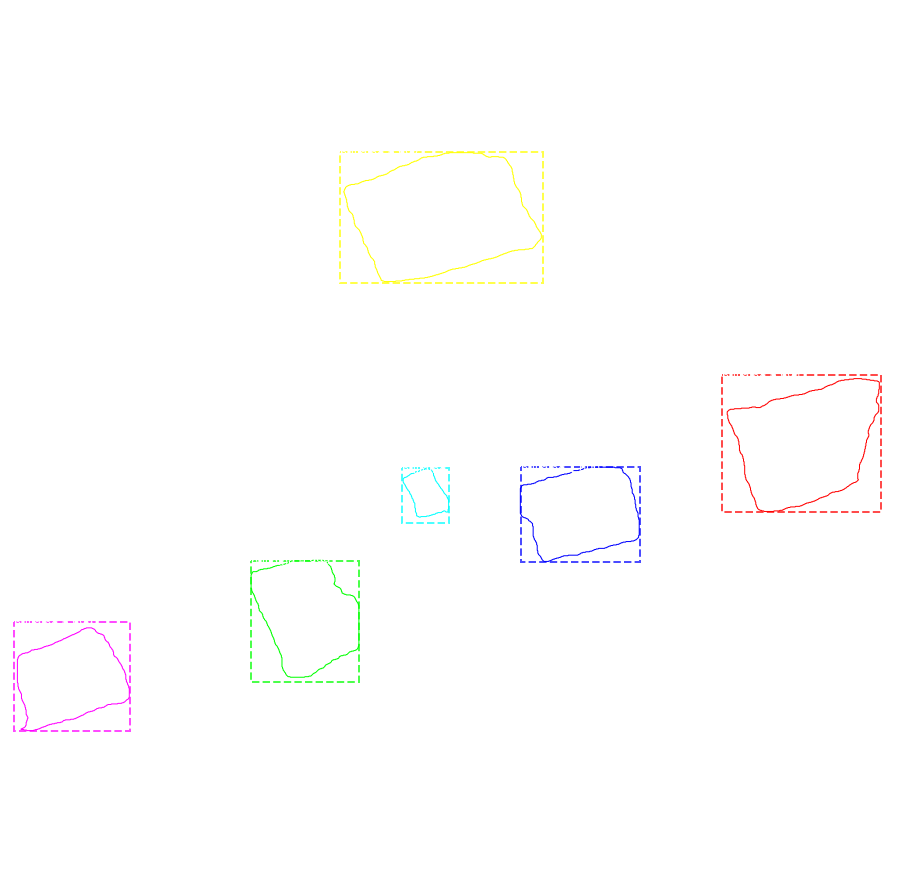

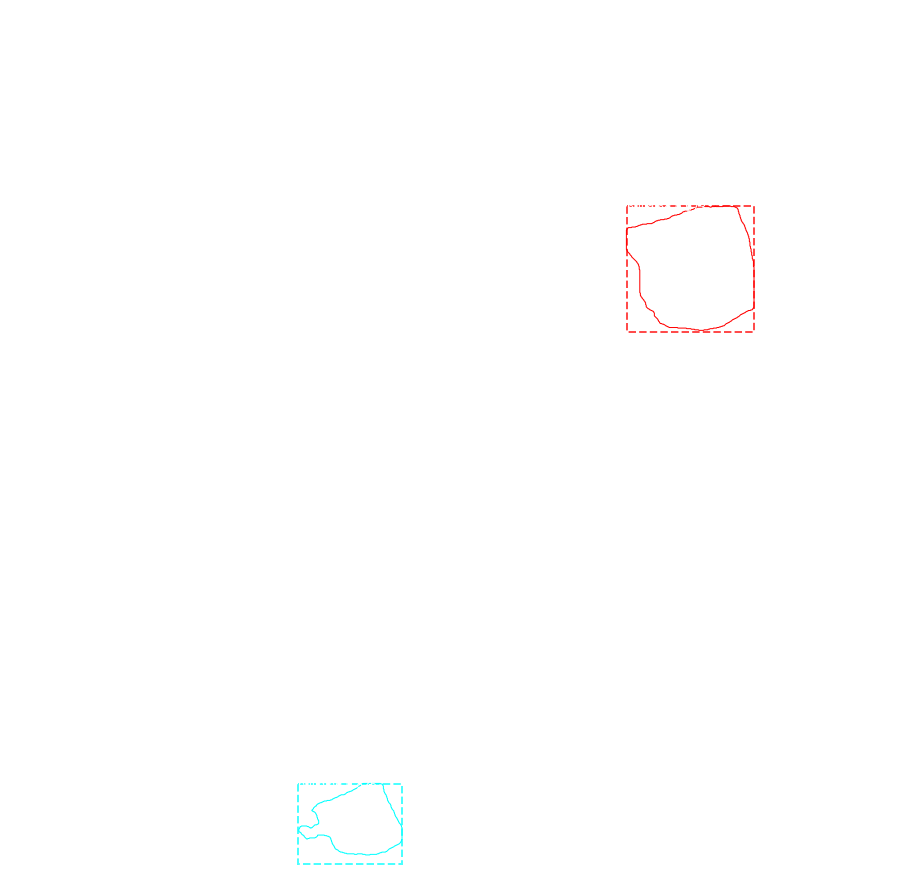

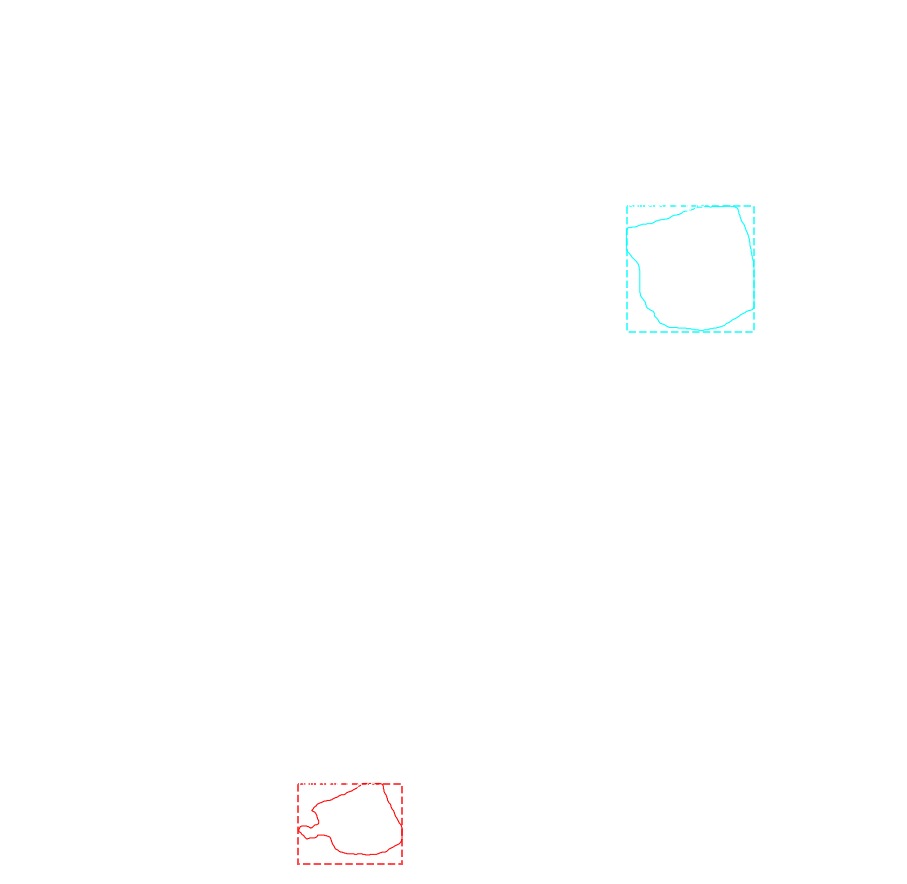

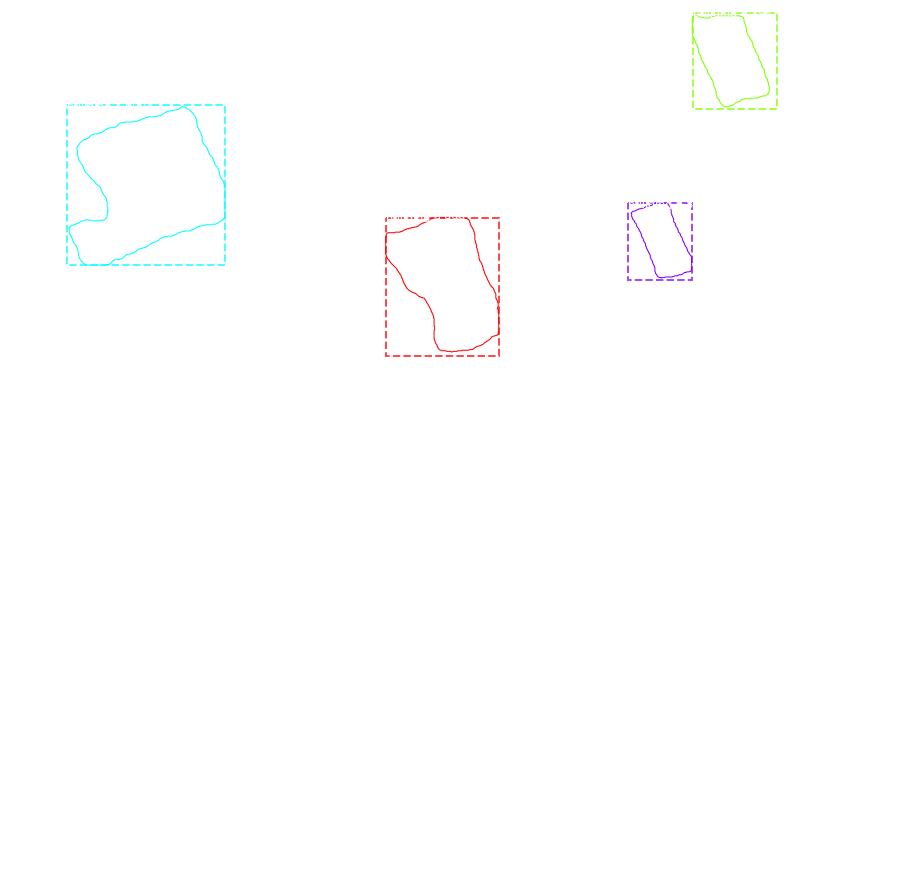

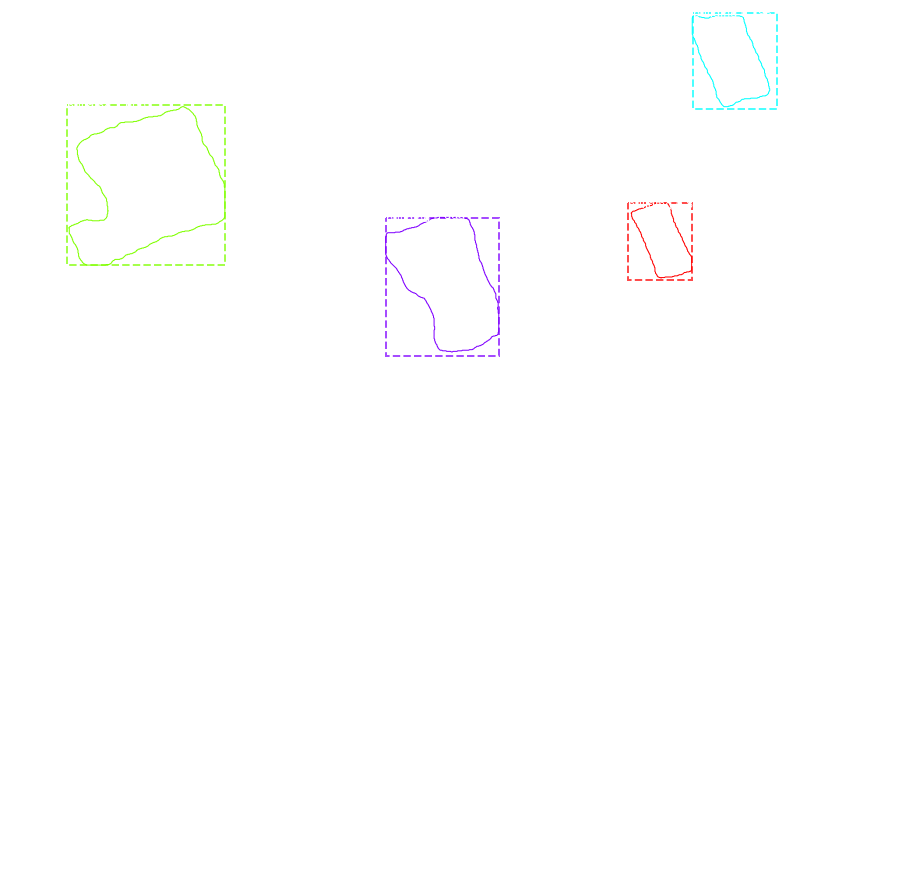

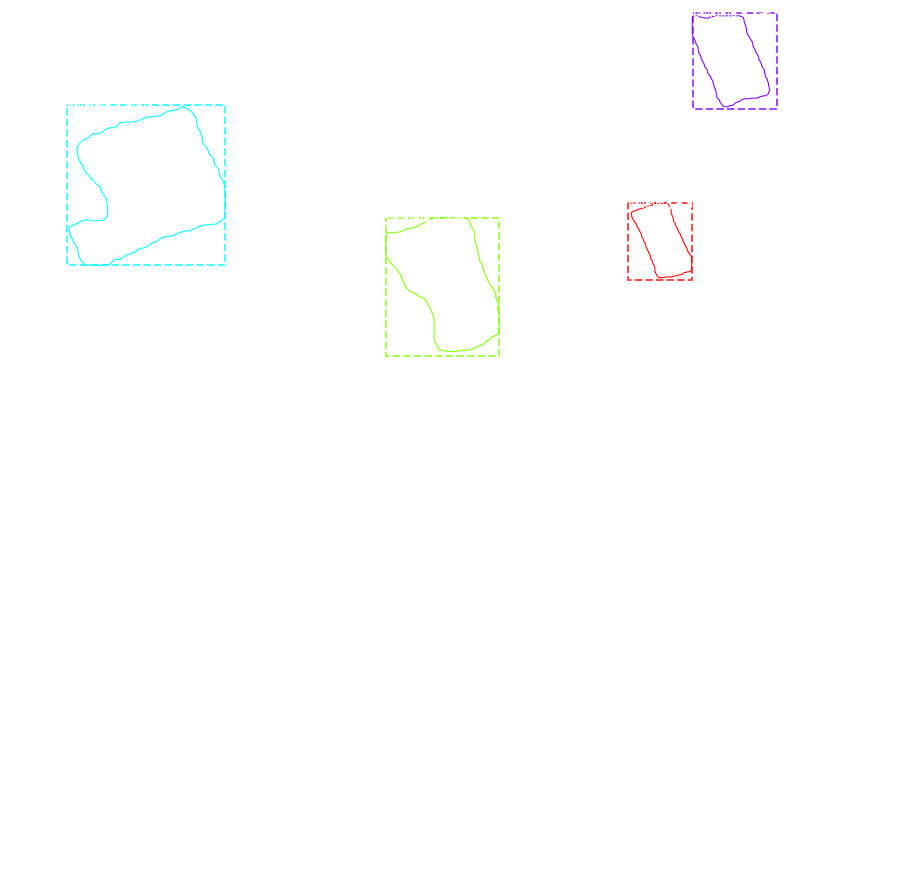

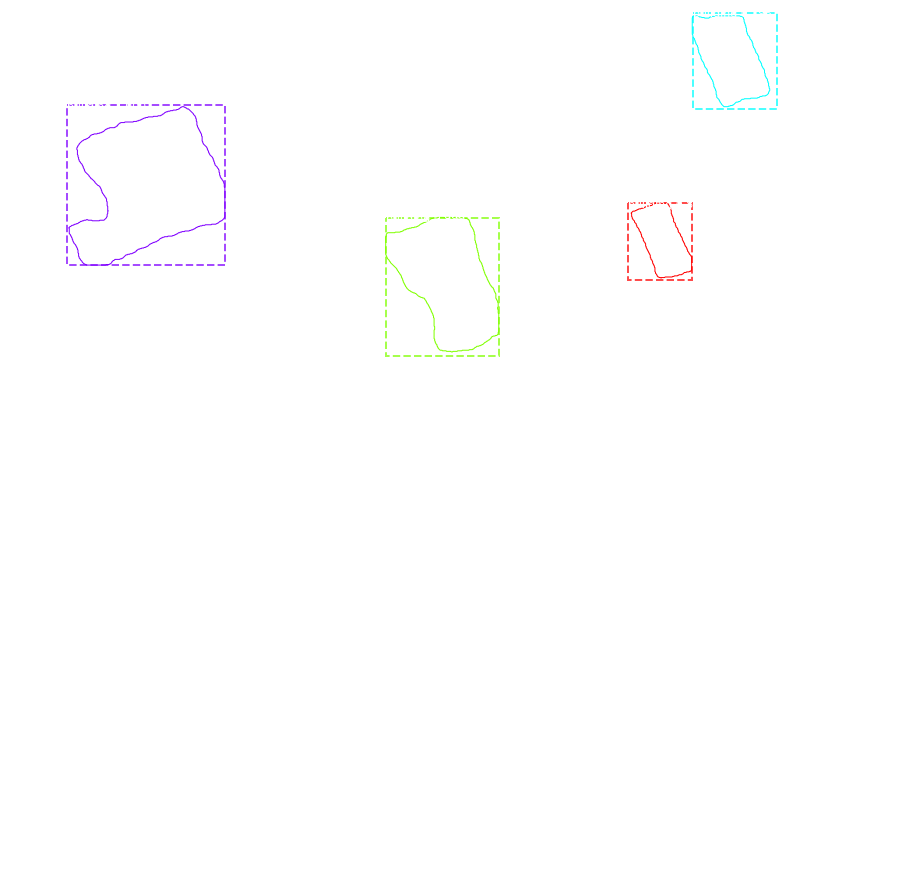

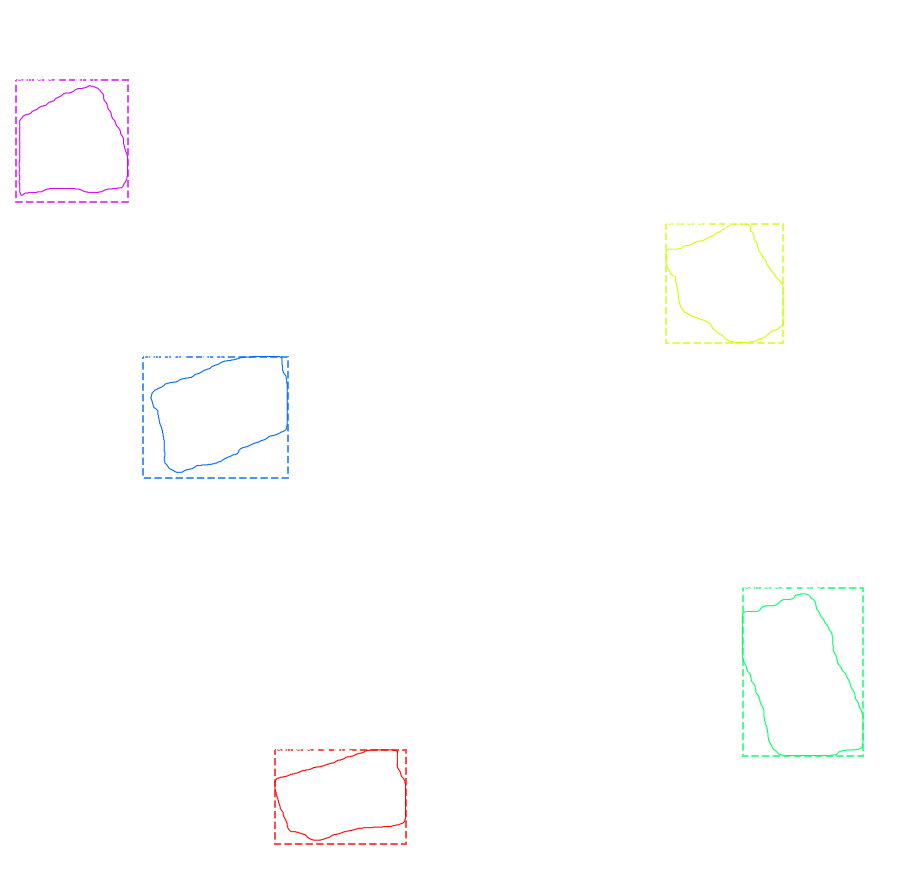

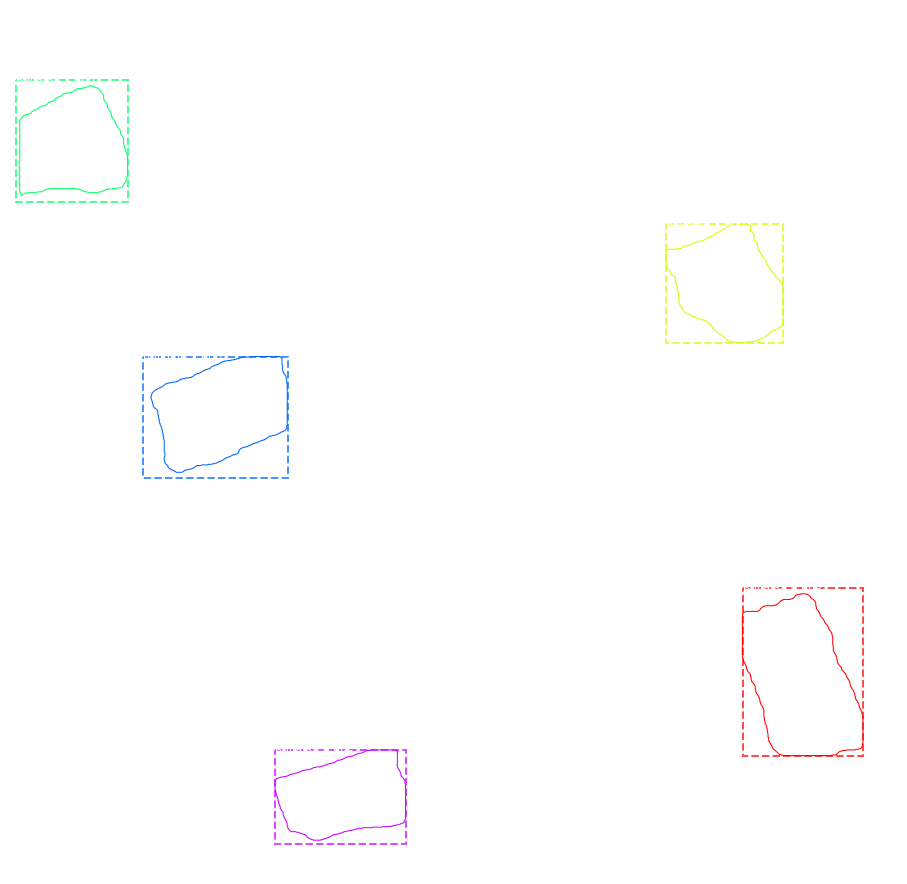

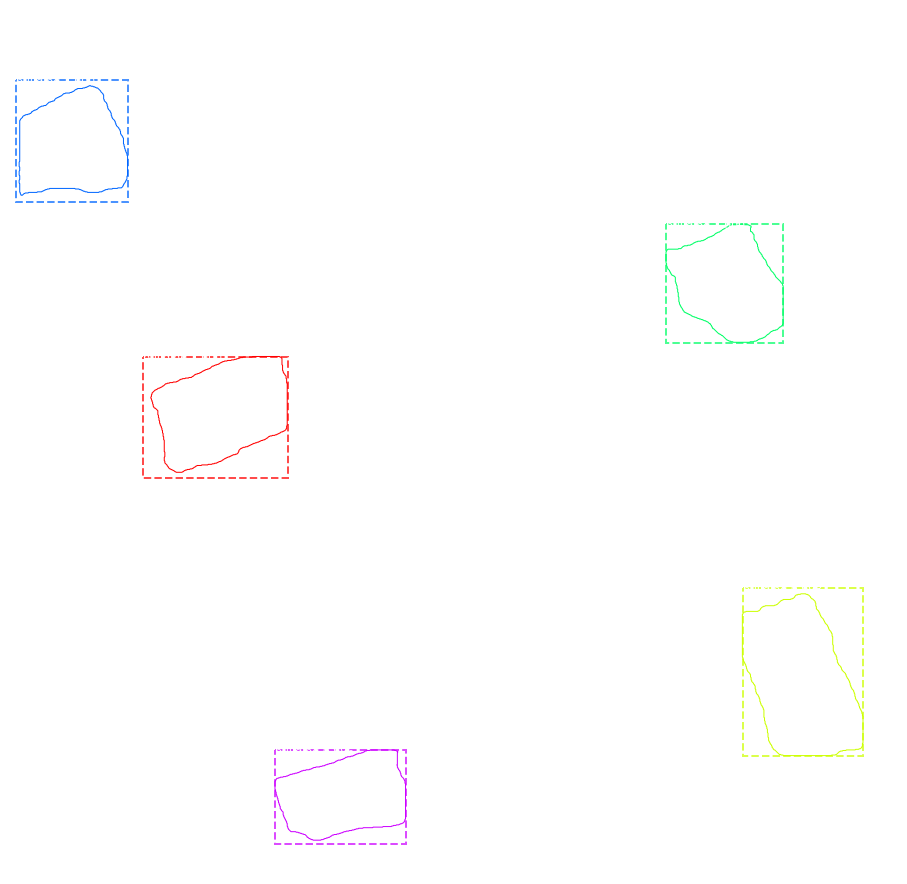

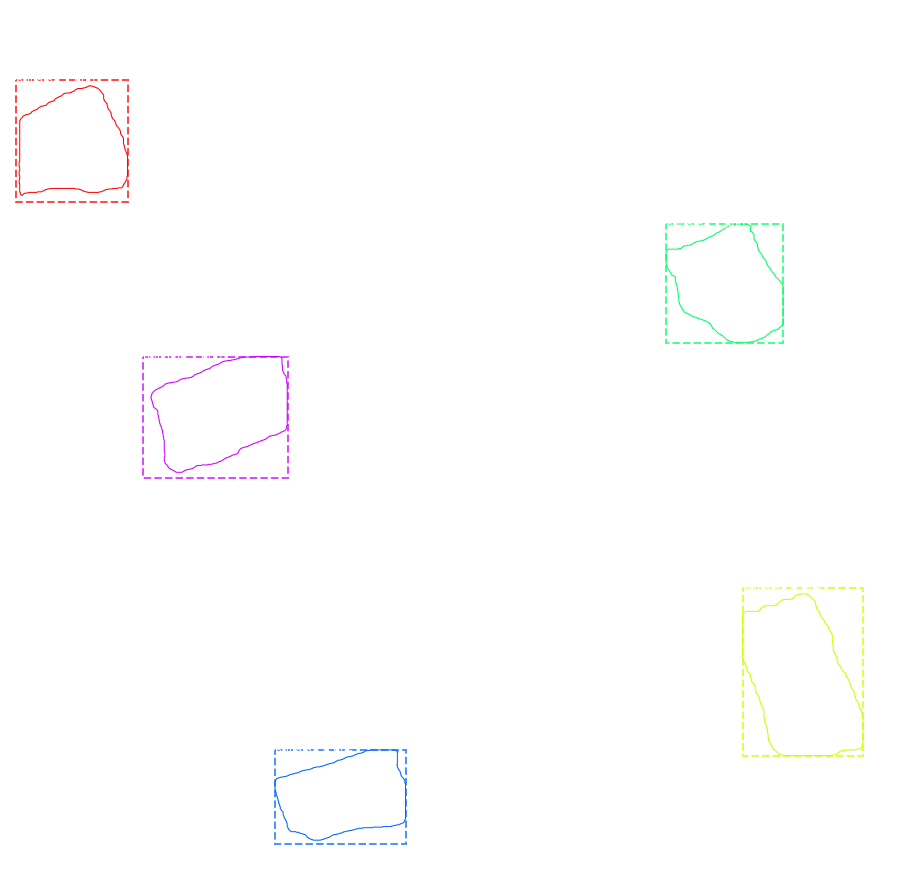

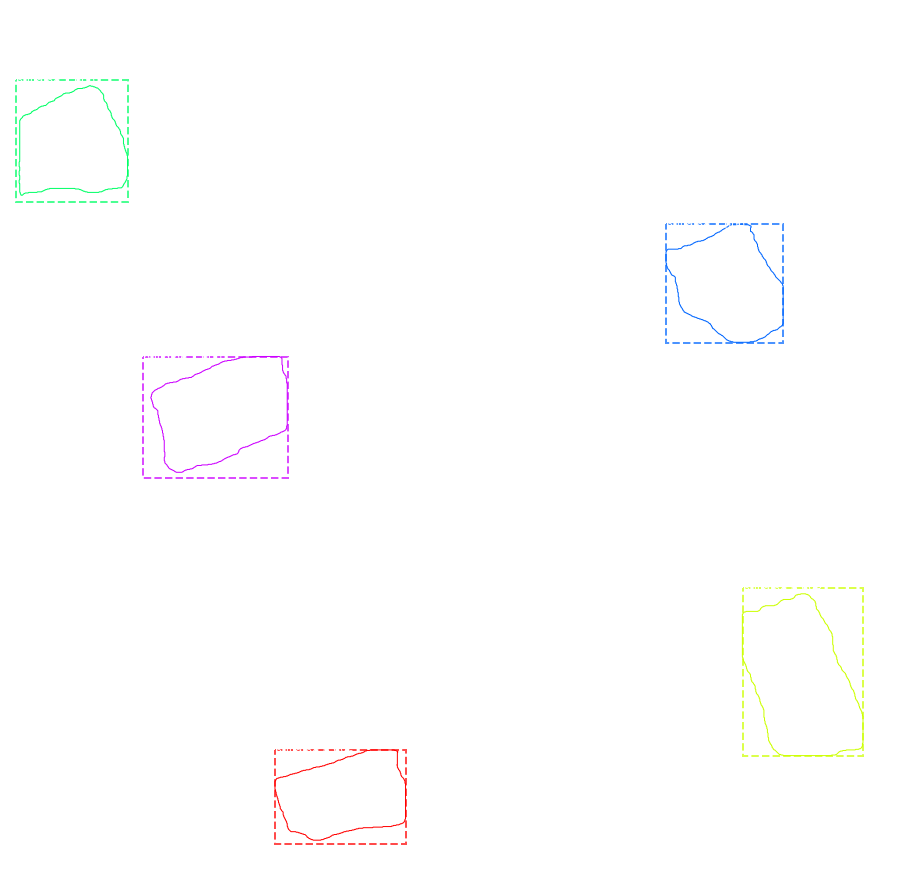

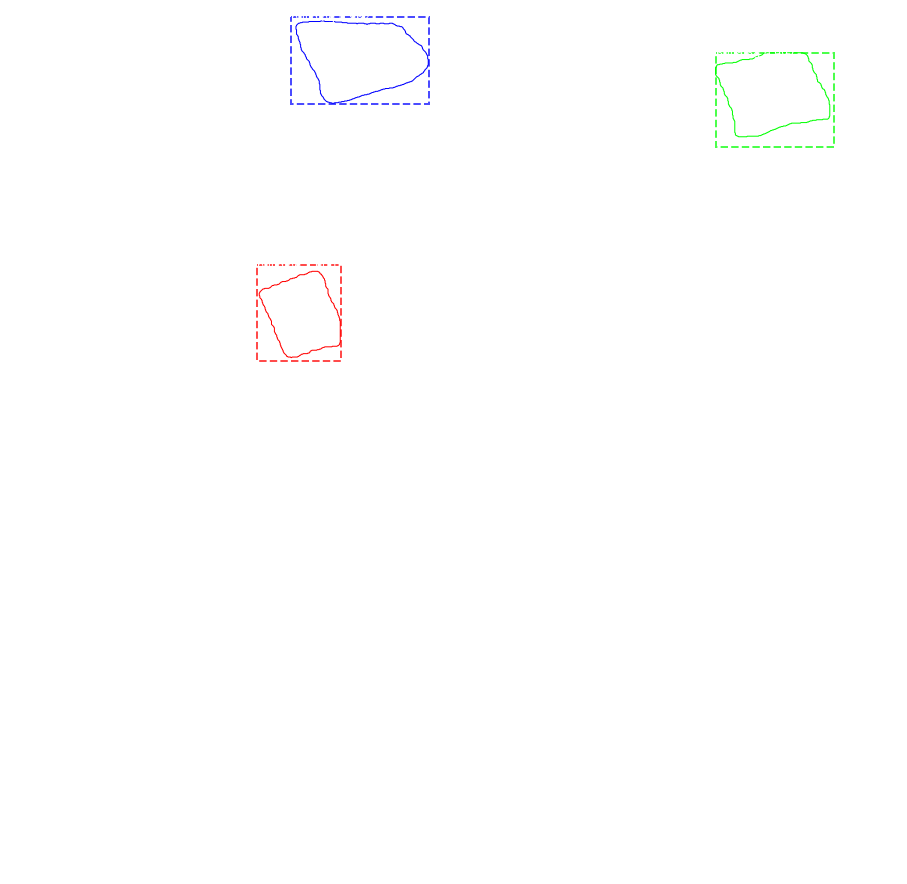

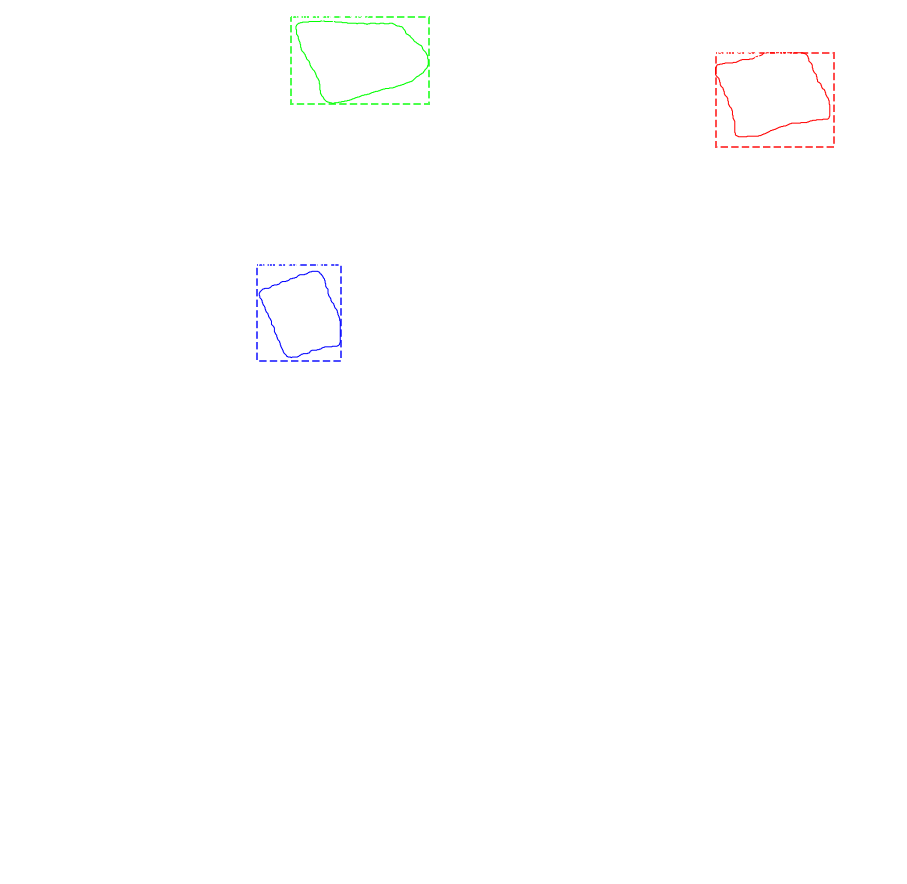

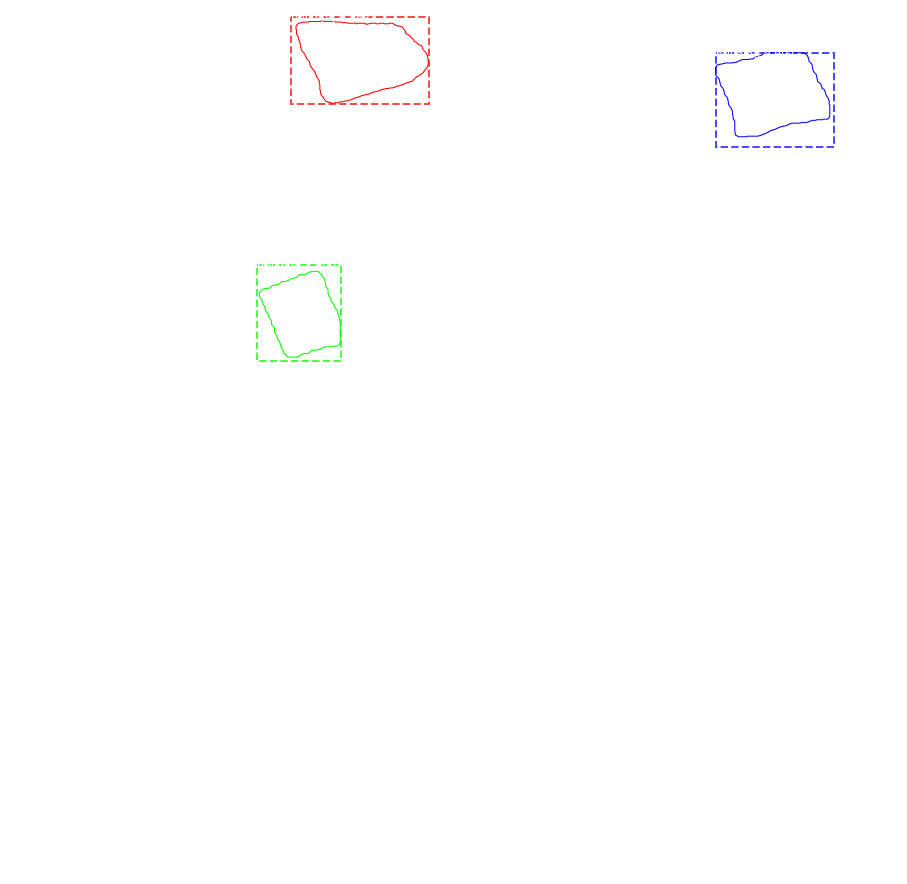

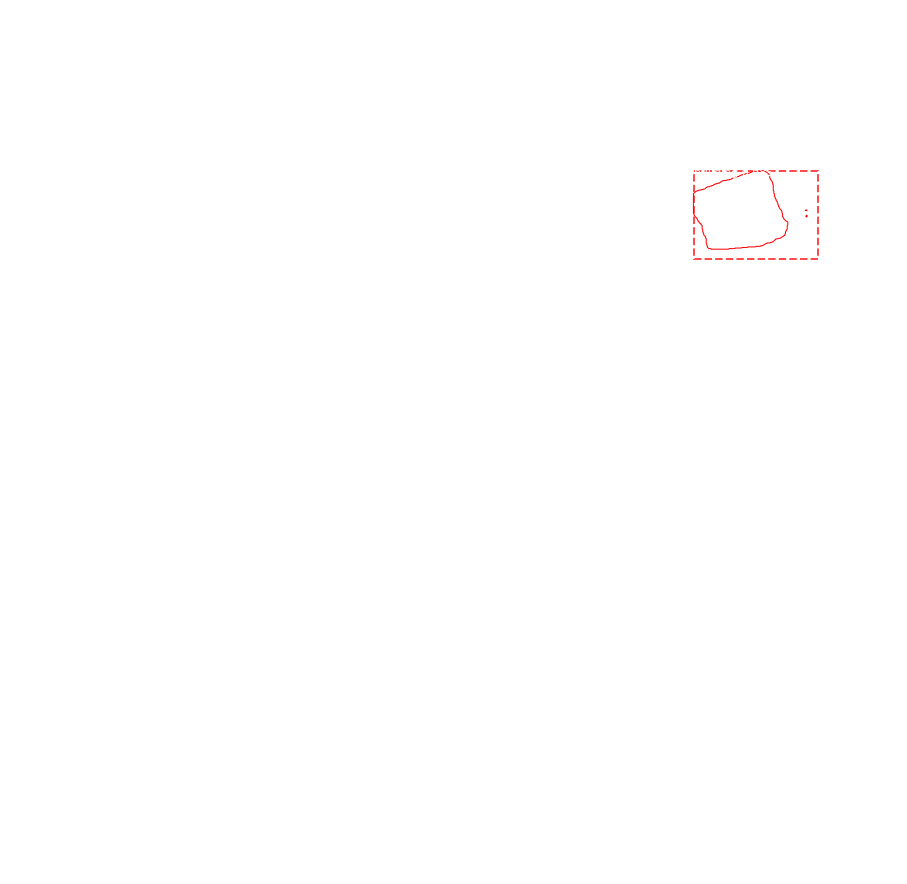

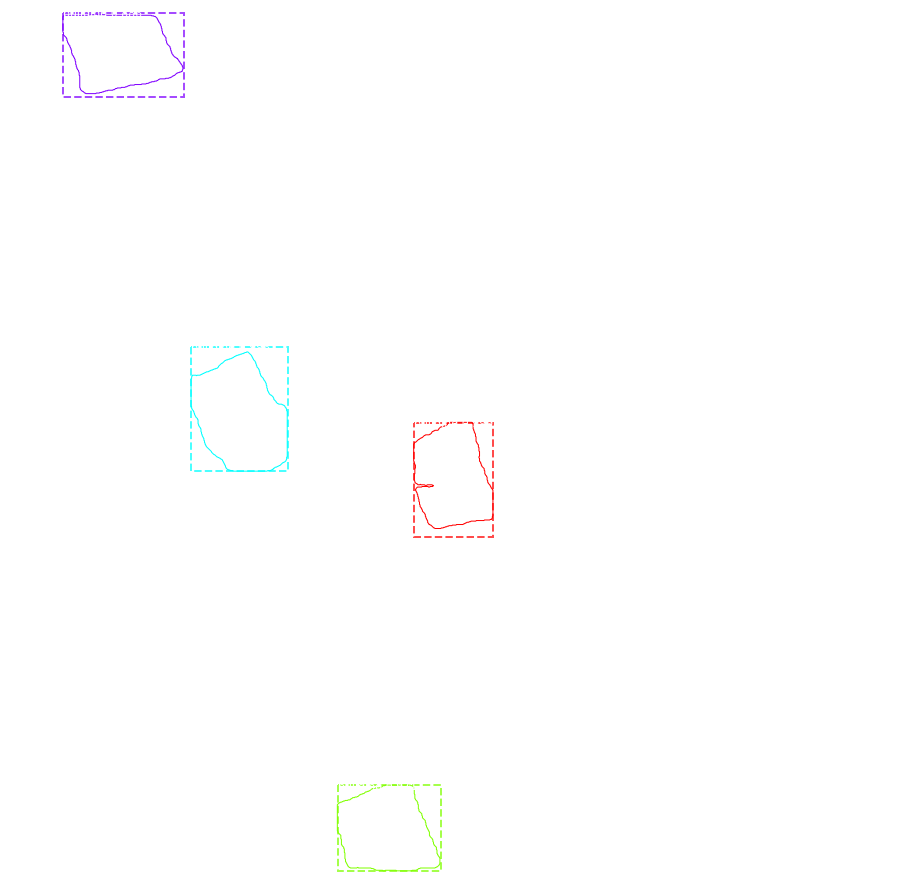

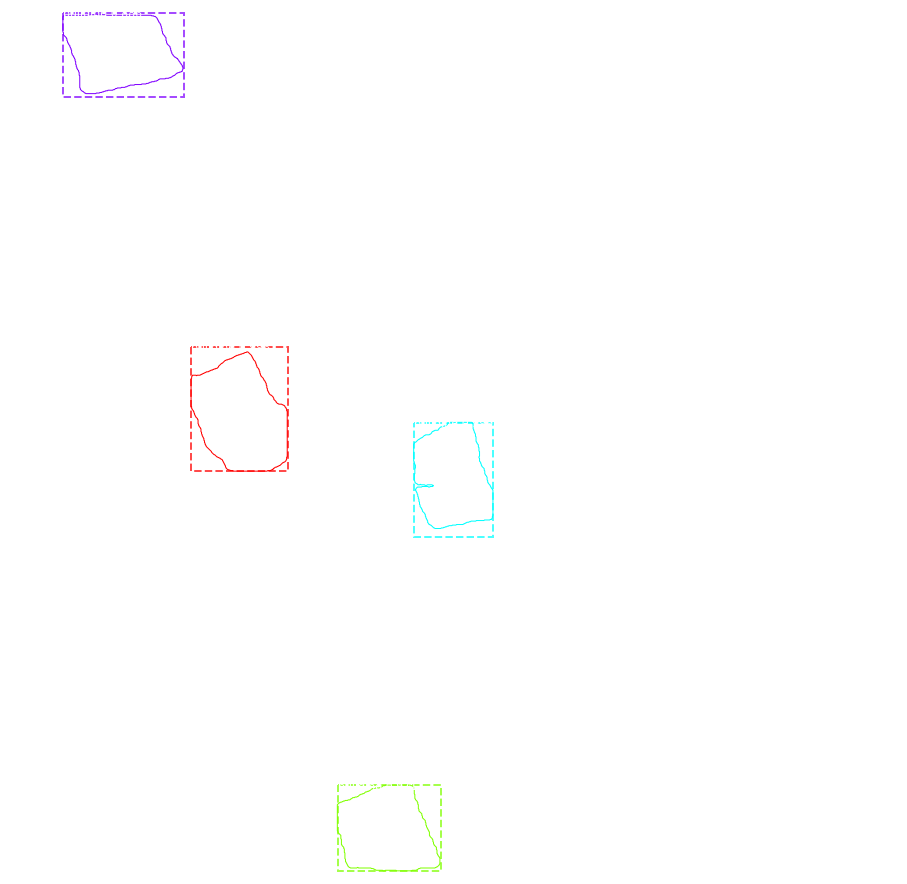

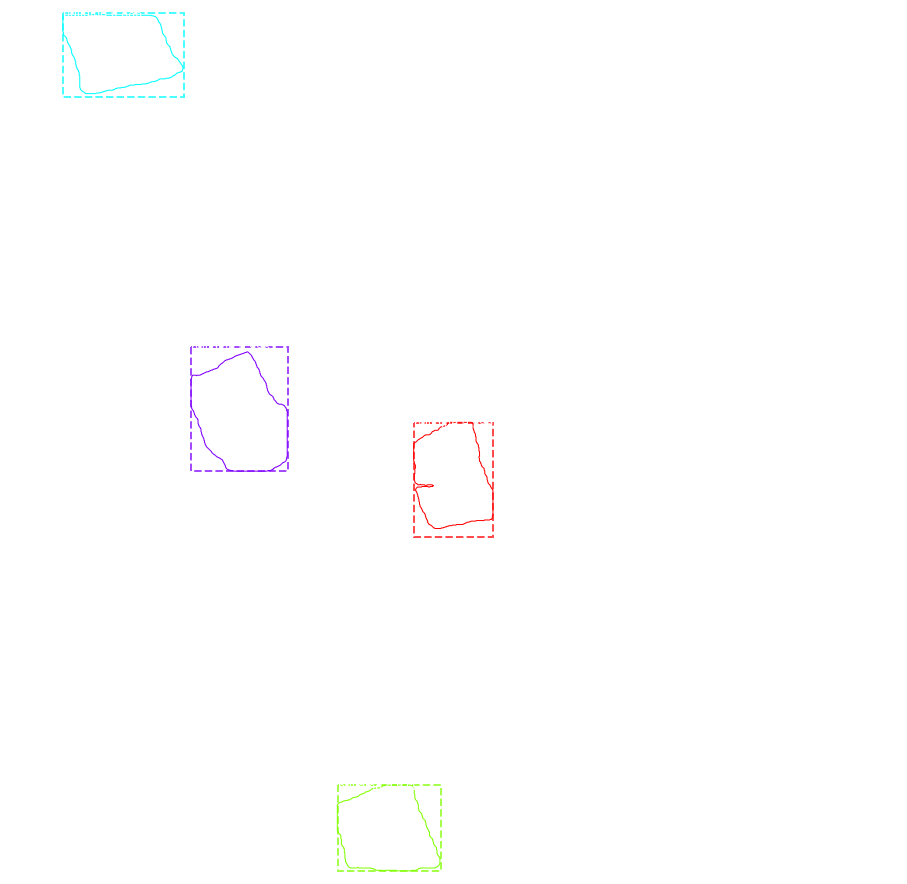

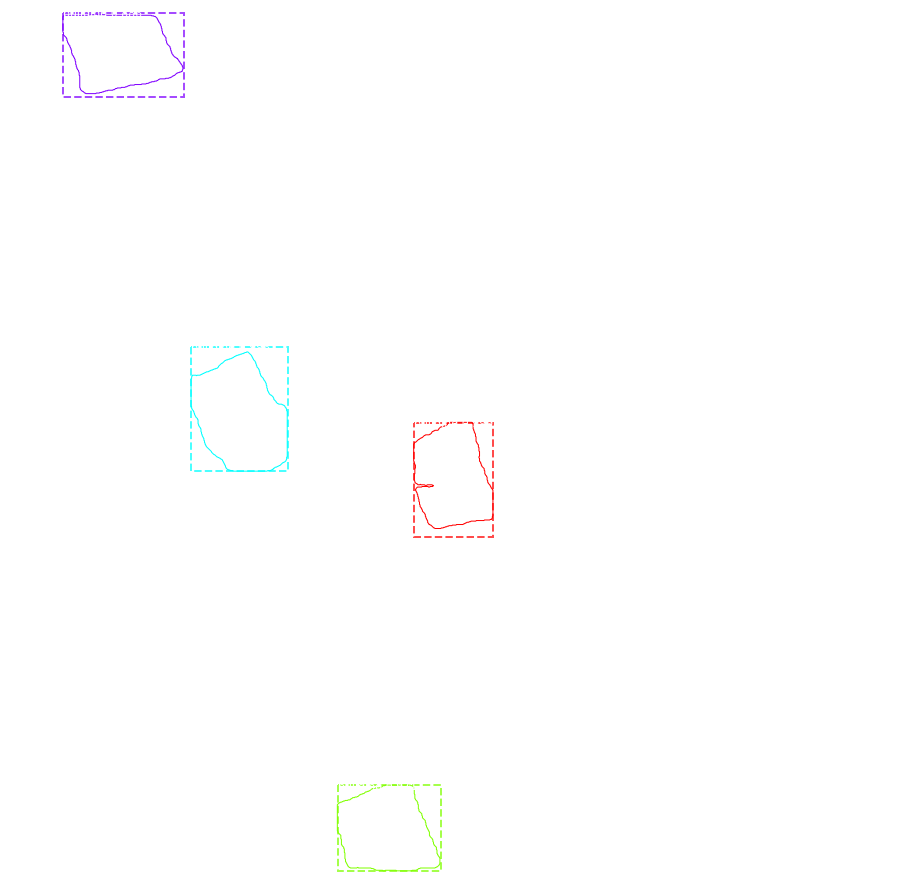

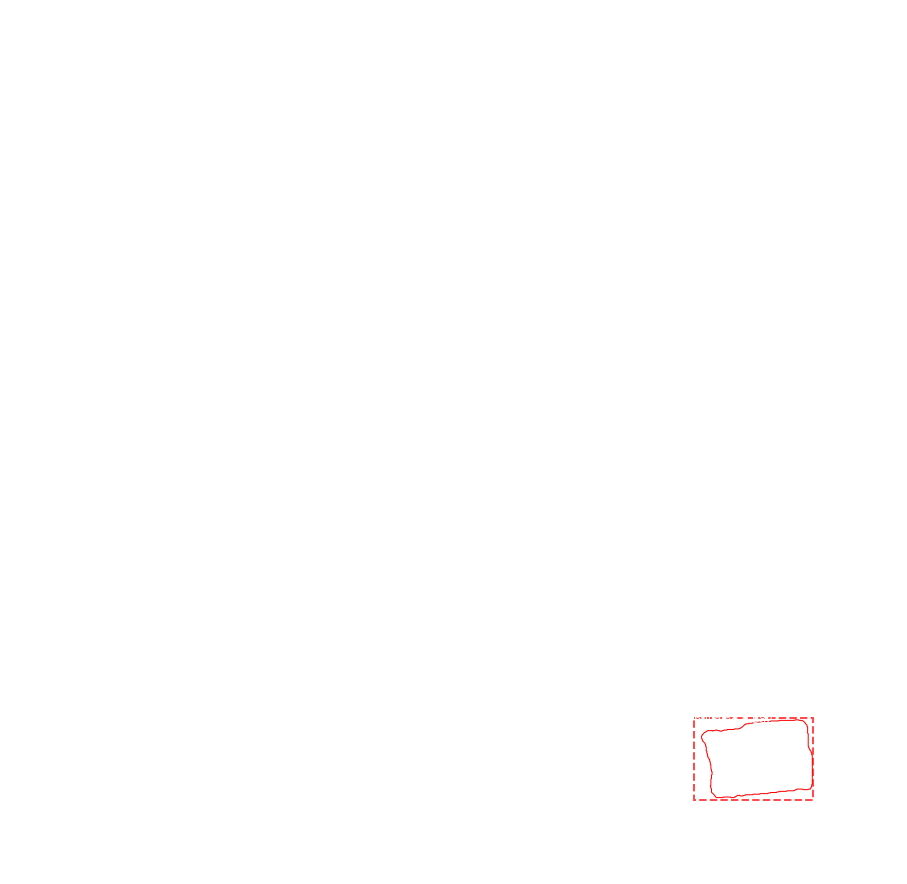

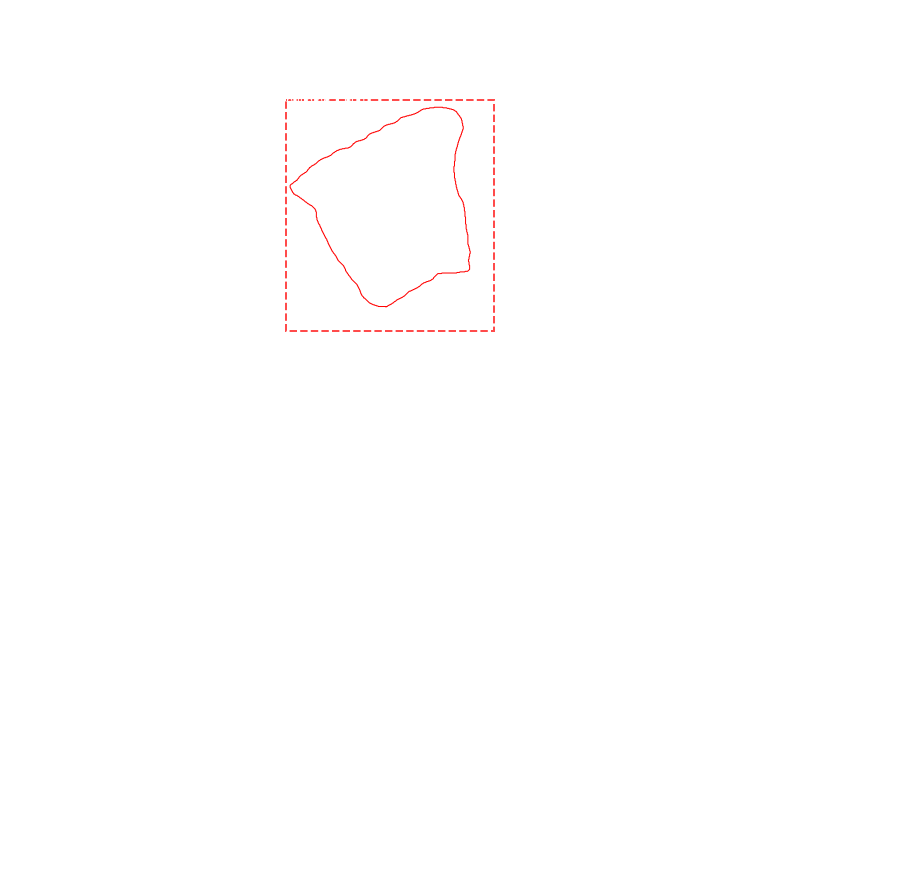

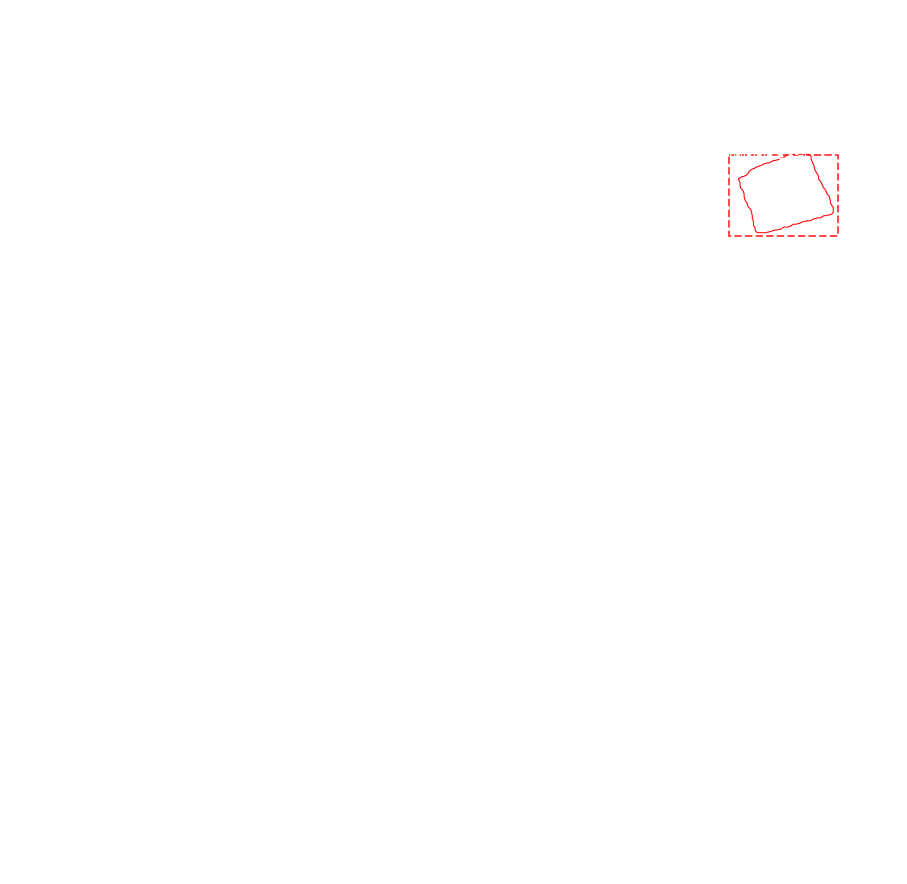

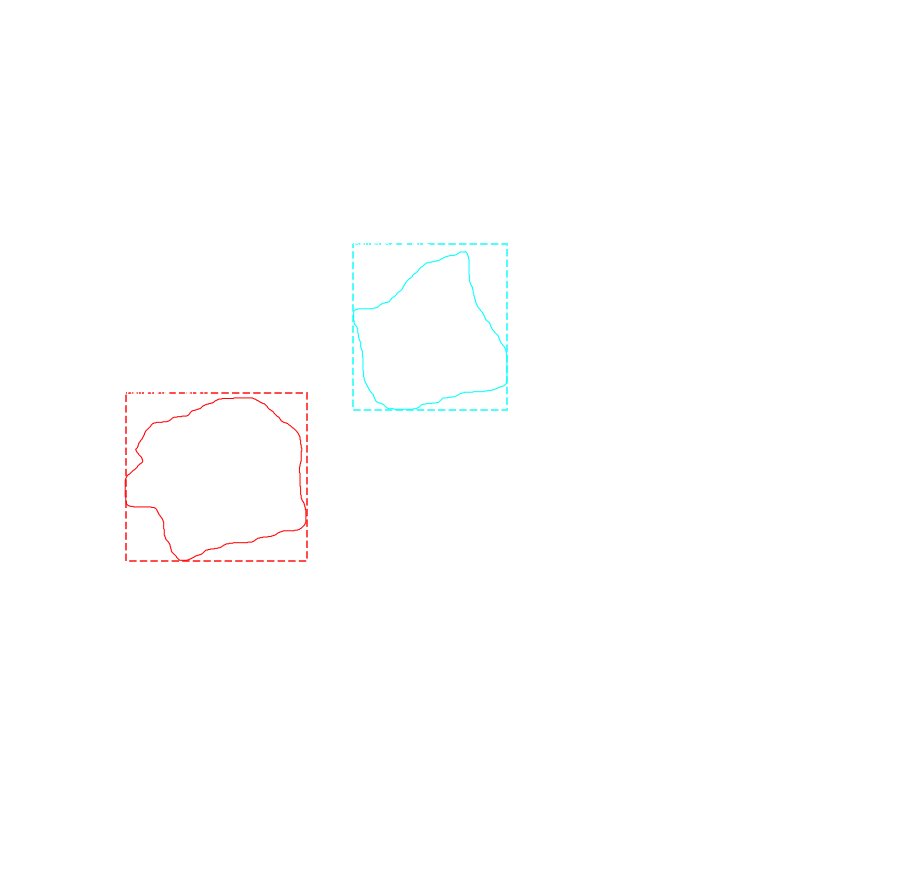

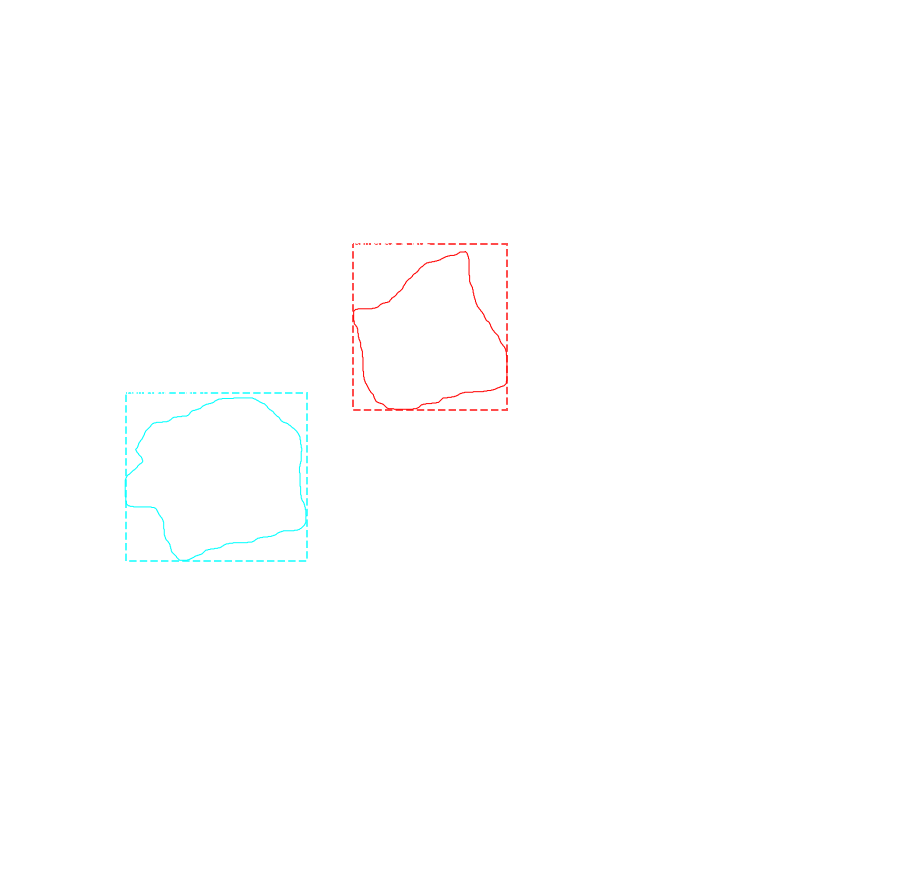

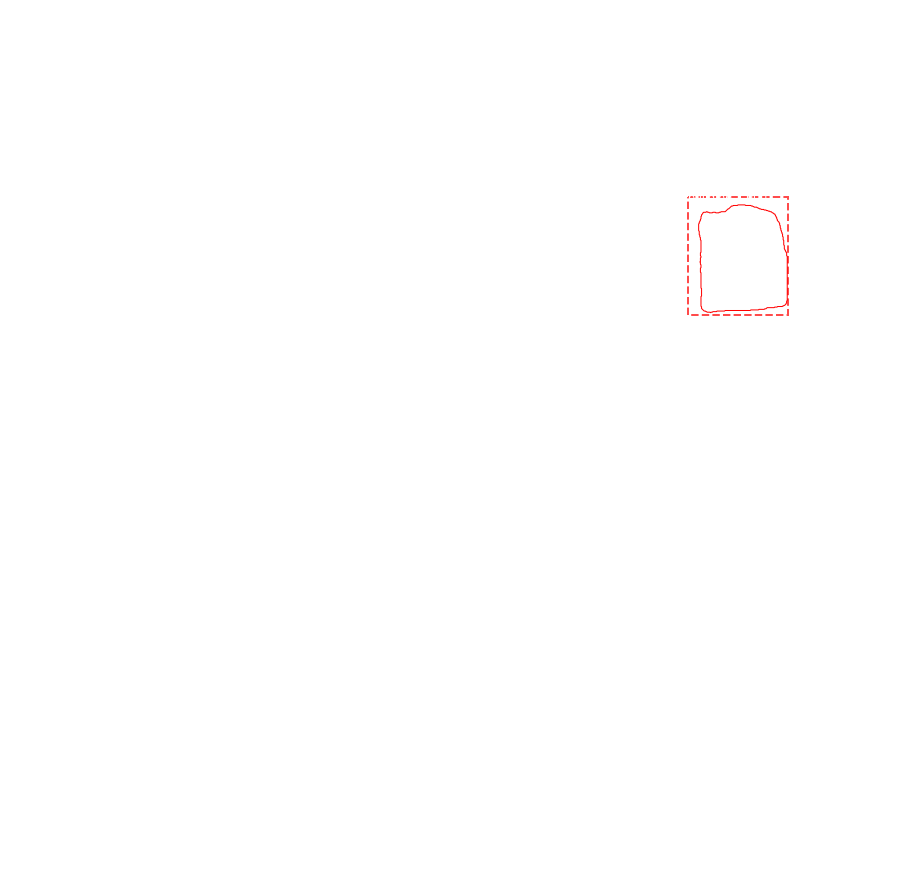

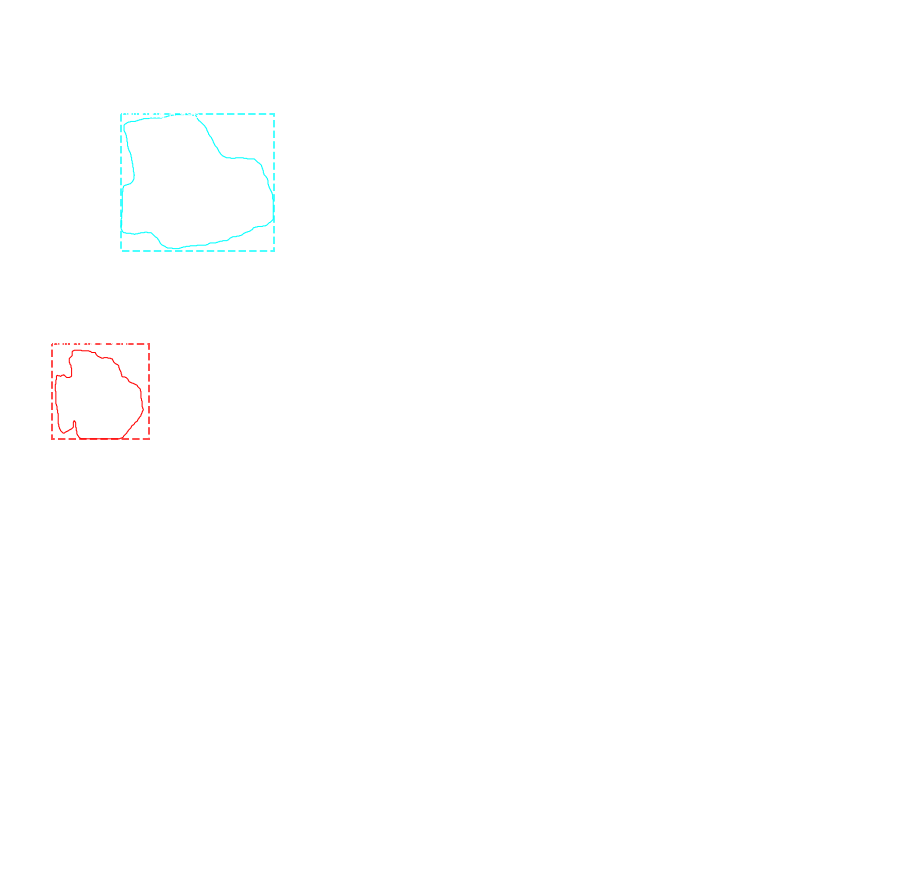

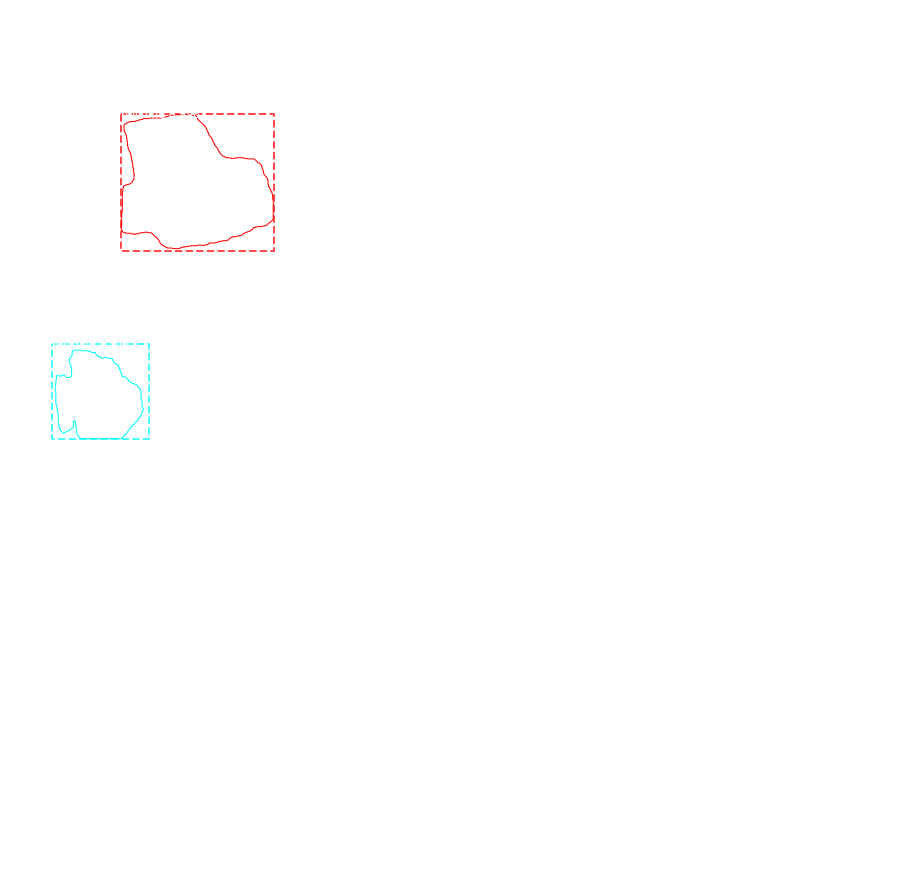

In [15]:
res, all_images = get_predict("./sand/v3.tif")

In [16]:
all_images

{(0,
  0): array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255

In [18]:
raster_array = tiff.imread("./sand/v3.tif")
W = raster_array.shape[0]
H = raster_array.shape[1]
new_image = np.zeros((W, H, 3), dtype=np.uint8)

w, h = (1512,1512)

for key, value in all_images.items():
    x = key[0]
    y = key[1]
    if x >= 0 and y >= 0:
        new_image[x:x+w,y:y+h] = value
    elif x >= 0:
        new_image[x:x+w,y:] = value
    elif y >= 0:
        new_image[x:,y:y+h] = value
    else:
        new_image[x:,y:] = value

In [19]:
plt.imsave('saved_im3_151212.png',new_image)

In [13]:
import json
with open('result3.json', 'w') as fp:
    json.dump(res, fp)

In [26]:
!pip freeze -> requirements.txt